In [1]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt
import math
from numpy import unravel_index
from PointProcess import PointProcessTrain
from PointProcess import PointProcessRun
from wasserstein import Cluster
from numpy import array

In [2]:
fields = ['XCOORD', 'YCOORD', 'CALL_TYPE_FINAL_D', 'CALL_TYPE_FINAL', 'DATE_TIME']
full_data = pd.read_csv('FixedLatLongTimeLoc_AndTimeSorted.csv', usecols=fields)
full_data['DATE_TIME'] =  pd.to_datetime(full_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full_data = full_data.sort_values(by='DATE_TIME')
save_loc = 'Trained_Params_70_50_day2.npz'

In [3]:
end = len(full_data)- 30000
start = end-400000
data = full_data[start:end]
data.reset_index(drop=True, inplace=True)
#reasonable results
#all_events = PointProcessTrain(data, w = [.05, .01, .005], final_param_save_loc = save_loc) 
#all_events = PointProcessTrain(data, w = [10, 1, .1], final_param_save_loc = save_loc) 
#all_events = PointProcessTrain(data, w = [10, 1, .5], final_param_save_loc = save_loc) 
#all_events = PointProcessTrain(data, w = [200, 100, .1], final_param_save_loc = save_loc) 
#this one is weirdly good w/auc w/ decay = False. W/decay=True I think it is better!!
#all_events = PointProcessTrain(data, w = [200, 100, .1], final_param_save_loc = save_loc) 
# decay = False, F = .01, No neg Lambdas for predictions
all_events = PointProcessTrain(data, w = [2, 1, .03],final_param_save_loc = save_loc, xgridsize = 70, ygridsize = 50) 



In [4]:
all_events.train()

0.25 percent trained
0.5 percent trained


KeyboardInterrupt: 

In [ ]:
all_events.param_examine()

In [ ]:
all_events.model_hotspot_examine(1000)

In [8]:
a = array([[3.70000000e+01, 1.80000000e+01, 1.59971417e-02]])
a[0]

array([3.70000000e+01, 1.80000000e+01, 1.59971417e-02])

#### Testing Projections w/Simulation

In [11]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')

test_points = full_data[end:end+50]
test_points.reset_index(drop=True,inplace=True)
ints,ig,pred,ig,ig,ig,ig,=simulation.test_projection(test_points, num_hotspots = 30, num_simulation_iters = 100)


Predicting over time of 0.1467364398 days. Generating 15 intensity prediction(s)
Events will be projected until 0.15625 days from now
[[1.10000000e+01 3.00000000e+01 7.17617249e-02]
 [1.80000000e+01 2.50000000e+01 1.19574917e-01]
 [2.30000000e+01 4.00000000e+00 4.67387317e-02]
 [2.30000000e+01 4.00000000e+00 6.52165478e-02]
 [2.70000000e+01 1.60000000e+01 2.53989653e-02]
 [3.40000000e+01 2.40000000e+01 1.65547546e-02]
 [3.50000000e+01 2.70000000e+01 5.81233066e-02]
 [3.80000000e+01 8.00000000e+00 9.02765591e-02]
 [3.80000000e+01 8.00000000e+00 9.96157602e-02]]
[0.9740836  0.99921257]


IndexError: too many indices for array

In [8]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')

test_points = full_data[end:end+50]
test_points.reset_index(drop=True,inplace=True)
ints,ig,pred,ig,ig,ig,ig,=simulation.test_projection(test_points, num_hotspots = 30, use_simulation=False)


Predicting over time of 0.1467364398 days. Generating 15 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 11.666666666666666. 
Hit number/Tot number: 0.1. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 58.738398173061576

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.4464355950904273, Real: 1.0
Grid: (27, 24), Model: 0.3720543832786044, Real: 1.0
Grid: (27, 31), Model: 0.20350533887382227, Real: 1.0
Grid: (29, 22), Model: 0.20227397990288962, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.3920175797737313, Real: 0.0
Grid: (26, 22), Model: 0.39076402327673804, Real: 0.0
Grid: (33, 25), Model: 0.24905183321211727, Real: 0.0
Grid: (28, 23), Model: 0.24871160318607655, Real: 0.0
Grid: (26, 23), Model: 0.23856530156960404, Real: 0.0
Grid: (32, 25), Model: 0.21071157931113865, Real: 0.0
Grid: (33, 23), Model: 0.20652780125656545, Real: 0.0
Grid: (27, 26), Model: 0.20628923890728862, Real: 0.0

#### Lets get results

In [7]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')

Timestamp('2016-07-29 09:58:56')

In [8]:
last_t = simulation._LastTime
indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600: # 1 hour in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_1h = []
real_num_1h = []
pai_1h = []
for i in range(0, 60):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0)
    pred_num_1h.append(sum(sum(pred)))
    real_num_1h.append(sum(sum(real)))
    pai_1h.append(pai)
    test_points.to_csv('for_results.csv')
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.0364815632 days. Generating 4 intensity prediction(s)
Events will be projected until 0.041666666666666664 days from now


IndexError: too many indices for array

In [13]:
#print(pred_num_1h, real_num_1h, pai_1h)
print(np.mean(pred_num_1h), np.mean(real_num_1h), np.mean(pai_1h), 
      np.median(pred_num_1h), np.median(real_num_1h), np.median(pai_1h))

13.50261372799591 14.466666666666667 13.828838161990896 14.64464000484233 15.0 11.666666666666666


In [14]:
pai_1h

[6.140350877192982,
 7.291666666666666,
 13.72549019607843,
 13.461538461538462,
 5.303030303030303,
 15.909090909090907,
 6.481481481481481,
 35.8974358974359,
 9.722222222222221,
 7.291666666666666,
 29.166666666666664,
 11.666666666666666,
 7.777777777777778,
 15.555555555555555,
 26.923076923076923,
 14.583333333333332,
 29.166666666666664,
 38.888888888888886,
 23.333333333333332,
 0.0,
 0.0,
 0.0,
 7.291666666666666,
 11.666666666666666,
 7.777777777777778,
 24.561403508771928,
 29.166666666666664,
 18.666666666666668,
 19.444444444444443,
 0.0,
 8.333333333333332,
 29.166666666666664,
 30.701754385964907,
 8.974358974358974,
 7.777777777777778,
 21.21212121212121,
 36.45833333333333,
 23.333333333333332,
 0.0,
 14.583333333333332,
 0.0,
 8.974358974358974,
 6.481481481481481,
 11.11111111111111,
 0.0,
 13.72549019607843,
 0.0,
 20.58823529411765,
 5.833333333333333,
 24.999999999999996,
 11.11111111111111,
 0.0,
 0.0,
 23.333333333333332,
 12.280701754385964,
 31.11111111111111,

In [15]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
simulation._LastTime

Timestamp('2016-07-29 09:58:56')

In [16]:
last_t = simulation._LastTime
indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*2: # 2 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_2h = []
real_num_2h = []
pai_2h = []
for i in range(0, 60):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0)
    pred_num_2h.append(sum(sum(pred)))
    real_num_2h.append(sum(sum(real)))
    pai_2h.append(pai)
    test_points.to_csv('for_results.csv')
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.0831367603 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 10.606060606060606. 
Hit number/Tot number: 0.09090909090909091. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.83530470700706

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.30031464075992226, Real: 1.0
Grid: (27, 24), Model: 0.28203387680367786, Real: 1.0
Grid: (28, 24), Model: 0.1433688985840923, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2986295108249763, Real: 0.0
Grid: (26, 22), Model: 0.28435056283023935, Real: 0.0
Grid: (28, 23), Model: 0.21285807907585838, Real: 0.0
Grid: (8, 38), Model: 0.19501030670933586, Real: 0.0
Grid: (14, 22), Model: 0.1876924627442602, Real: 0.0
Grid: (11, 35), Model: 0.16508897974901826, Real: 0.0
Grid: (26, 23), Model: 0.16018631038024214, Real: 0.0
Grid: (0, 31), Model: 0.15934210946422303, Real: 0.0
Grid: (33, 25), Model: 0.1588019035905190

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



Predicting over time of 0.0766784125 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 24.305555555555557. 
Hit number/Tot number: 0.20833333333333334. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.07980025652204

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.22139340373409044, Real: 1.0
Grid: (44, 32), Model: 0.1188450518006802, Real: 1.0
Grid: (35, 32), Model: 0.11713890590945505, Real: 1.0
Grid: (36, 24), Model: 0.11426136579074585, Real: 1.0
Grid: (33, 24), Model: 0.11247180461333078, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3095232173420535, Real: 0.0
Grid: (27, 23), Model: 0.3067411256255826, Real: 0.0
Grid: (27, 24), Model: 0.2892389544628313, Real: 0.0
Grid: (26, 22), Model: 0.2796910705316635, Real: 0.0
Grid: (8, 38), Model: 0.19562270235075155, Real: 0.0
Grid: (14, 22), Model: 0.18875392201523283, Real: 0.0
Grid: (11, 35), Model: 0.1660376736679871,

4.0

The predictive accuracy index for 30 hotspots is: 17.28395061728395. 
Hit number/Tot number: 0.14814814814814814. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 17.669292924913215

Predicted hotspots in real top 30
Grid: (28, 24), Model: 0.07571110869798282, Real: 1.0
Grid: (27, 26), Model: 0.07091791924594476, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.16526552297165, Real: 0.0
Grid: (27, 23), Model: 0.1641513566535354, Real: 0.0
Grid: (27, 24), Model: 0.1552375598227765, Real: 0.0
Grid: (26, 22), Model: 0.15039044381133307, Real: 0.0
Grid: (28, 23), Model: 0.11928564239833994, Real: 0.0
Grid: (8, 38), Model: 0.10451369260830647, Real: 0.0
Grid: (14, 22), Model: 0.10095744015439995, Real: 0.0
Grid: (11, 35), Model: 0.08881318565390171, Real: 0.0
Grid: (0, 31), Model: 0.08572157172810113, Real: 0.0
Grid: (26, 23), Model: 0.08267156560628652, Real: 0.0
Grid: (33, 25), Model: 0.08085687168423449, Real: 0.0
Grid: (27, 31), 


Predicting over time of 0.0827895373 days. Generating 8 intensity prediction(s)
1.0

The predictive accuracy index for 30 hotspots is: 3.5353535353535355. 
Hit number/Tot number: 0.030303030303030304. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.46739306212598

Predicted hotspots in real top 30
Grid: (27, 26), Model: 0.1301286146957014, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2763253576984474, Real: 0.0
Grid: (27, 23), Model: 0.2678307072934729, Real: 0.0
Grid: (26, 22), Model: 0.2552476029659765, Real: 0.0
Grid: (27, 24), Model: 0.25361307431802316, Real: 0.0
Grid: (28, 23), Model: 0.19905969588434408, Real: 0.0
Grid: (8, 38), Model: 0.17463114448687567, Real: 0.0
Grid: (14, 22), Model: 0.16887243591640116, Real: 0.0
Grid: (11, 35), Model: 0.14857440675012573, Real: 0.0
Grid: (0, 31), Model: 0.14340253320629803, Real: 0.0
Grid: (28, 24), Model: 0.13627559831597932, Real: 0.0
Grid: (26, 23), Model: 0.1361834791944833

6.0

The predictive accuracy index for 30 hotspots is: 17.94871794871795. 
Hit number/Tot number: 0.15384615384615385. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.76817385556215

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.3003708232934501, Real: 1.0
Grid: (27, 24), Model: 0.2955607748604157, Real: 1.0
Grid: (27, 26), Model: 0.15178240690964911, Real: 1.0
Grid: (32, 25), Model: 0.14188289440927793, Real: 1.0
Grid: (37, 23), Model: 0.1200346729564423, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3250383458607606, Real: 0.0
Grid: (27, 23), Model: 0.31200660199269414, Real: 0.0
Grid: (28, 23), Model: 0.2425458837956335, Real: 0.0
Grid: (8, 38), Model: 0.2052150581778075, Real: 0.0
Grid: (14, 22), Model: 0.1985196044442308, Real: 0.0
Grid: (11, 35), Model: 0.17466854540343, Real: 0.0
Grid: (0, 31), Model: 0.16858836675966096, Real: 0.0
Grid: (26, 23), Model: 0.15908996324036526, Real: 0.0
Grid: (33, 25), Model:


Predicting over time of 0.0820256467 days. Generating 8 intensity prediction(s)
8.0

The predictive accuracy index for 30 hotspots is: 32.183908045977006. 
Hit number/Tot number: 0.27586206896551724. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 15.379254455403515

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.14603189382547274, Real: 2.0
Grid: (26, 23), Model: 0.0717327485131792, Real: 1.0
Grid: (33, 25), Model: 0.07144789787770732, Real: 1.0
Grid: (34, 24), Model: 0.06210400216198654, Real: 2.0
Grid: (36, 24), Model: 0.053804809084007046, Real: 1.0
Grid: (51, 33), Model: 0.05206341002928664, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.14750121884943662, Real: 0.0
Grid: (26, 22), Model: 0.13147047698718314, Real: 0.0
Grid: (27, 24), Model: 0.1307341836273832, Real: 0.0
Grid: (28, 23), Model: 0.10363425352224354, Real: 0.0
Grid: (8, 38), Model: 0.09044398286126644, Real: 0.0
Grid: (14, 22), Model: 0.087520746493


Predicting over time of 0.0791205476 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 12.280701754385964. 
Hit number/Tot number: 0.10526315789473684. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 24.136642114064433

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.23479381320823467, Real: 2.0
Grid: (26, 22), Model: 0.21097386192585701, Real: 1.0
Grid: (26, 26), Model: 0.08036240260262226, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.22433612688492555, Real: 0.0
Grid: (27, 24), Model: 0.20363564548756247, Real: 0.0
Grid: (28, 23), Model: 0.16028130753807202, Real: 0.0
Grid: (8, 38), Model: 0.1424420371601819, Real: 0.0
Grid: (14, 22), Model: 0.1378632361099274, Real: 0.0
Grid: (11, 35), Model: 0.12131906979074261, Real: 0.0
Grid: (0, 31), Model: 0.11709603557456844, Real: 0.0
Grid: (26, 23), Model: 0.11433307142083293, Real: 0.0
Grid: (33, 25), Model: 0.11296567194866


Predicting over time of 0.08200249849999999 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 17.676767676767675. 
Hit number/Tot number: 0.15151515151515152. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 36.70977301011243

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.31920271032920783, Real: 1.0
Grid: (27, 24), Model: 0.30641069538766963, Real: 1.0
Grid: (28, 23), Model: 0.24044821337782837, Real: 1.0
Grid: (36, 24), Model: 0.12932940135901091, Real: 1.0
Grid: (33, 24), Model: 0.12446804500254387, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3655367724533644, Real: 0.0
Grid: (27, 23), Model: 0.3340711161309042, Real: 0.0
Grid: (8, 38), Model: 0.2155947906026151, Real: 0.0
Grid: (14, 22), Model: 0.2086818850782669, Real: 0.0
Grid: (11, 35), Model: 0.1836495823433762, Real: 0.0
Grid: (0, 31), Model: 0.1772568977177683, Real: 0.0
Grid: (26, 23), Model: 0.170180700672


Predicting over time of 0.0827432409 days. Generating 8 intensity prediction(s)
8.0

The predictive accuracy index for 30 hotspots is: 26.666666666666664. 
Hit number/Tot number: 0.22857142857142856. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.41732171242359

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.2636659098715441, Real: 2.0
Grid: (26, 22), Model: 0.25527018568353566, Real: 1.0
Grid: (27, 24), Model: 0.25344887624368473, Real: 2.0
Grid: (33, 25), Model: 0.13202086213226125, Real: 1.0
Grid: (36, 24), Model: 0.11278246289206399, Real: 1.0
Grid: (29, 20), Model: 0.11130242013266448, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.28752101566719485, Real: 0.0
Grid: (28, 23), Model: 0.20120074327166393, Real: 0.0
Grid: (8, 38), Model: 0.17212150683695362, Real: 0.0
Grid: (14, 22), Model: 0.1666117303288212, Real: 0.0
Grid: (11, 35), Model: 0.14663416343428673, Real: 0.0
Grid: (0, 31), Model: 0.141529979522339


Predicting over time of 0.08312518619999999 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 10.0. 
Hit number/Tot number: 0.08571428571428572. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 21.822900502444934

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.21023275038174155, Real: 2.0
Grid: (29, 22), Model: 0.0847173185993391, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2063937087243184, Real: 0.0
Grid: (27, 24), Model: 0.19055551186891065, Real: 0.0
Grid: (26, 22), Model: 0.1883505307918899, Real: 0.0
Grid: (28, 23), Model: 0.14572031783528328, Real: 0.0
Grid: (8, 38), Model: 0.12874603839940543, Real: 0.0
Grid: (14, 22), Model: 0.12463103770645088, Real: 0.0
Grid: (11, 35), Model: 0.10969750197430436, Real: 0.0
Grid: (0, 31), Model: 0.10587907752338732, Real: 0.0
Grid: (33, 25), Model: 0.09975526048760484, Real: 0.0
Grid: (26, 23), Model: 0.09910204477171547, Rea


Predicting over time of 0.0829052783 days. Generating 8 intensity prediction(s)
7.0

The predictive accuracy index for 30 hotspots is: 17.375886524822693. 
Hit number/Tot number: 0.14893617021276595. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.772774287193016

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.334547812634247, Real: 1.0
Grid: (27, 24), Model: 0.30539231602076694, Real: 1.0
Grid: (27, 31), Model: 0.15633333087342763, Real: 2.0
Grid: (28, 24), Model: 0.1519987254019295, Real: 1.0
Grid: (27, 26), Model: 0.14966250527334415, Real: 1.0
Grid: (29, 20), Model: 0.1398166179914318, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.35320263777353156, Real: 0.0
Grid: (26, 22), Model: 0.3025227851456906, Real: 0.0
Grid: (28, 23), Model: 0.23463634085582802, Real: 0.0
Grid: (8, 38), Model: 0.209730114153319, Real: 0.0
Grid: (14, 22), Model: 0.20302929307483233, Real: 0.0
Grid: (11, 35), Model: 0.17871198161256774,


Predicting over time of 0.0822687028 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 15.053763440860214. 
Hit number/Tot number: 0.12903225806451613. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 31.071908137657022

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.3026644783452543, Real: 2.0
Grid: (27, 26), Model: 0.13096976452982118, Real: 1.0
Grid: (26, 32), Model: 0.10940170206010343, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2871866075763918, Real: 0.0
Grid: (27, 24), Model: 0.2795007030540925, Real: 0.0
Grid: (26, 22), Model: 0.25755448561702, Real: 0.0
Grid: (28, 23), Model: 0.2054469173364545, Real: 0.0
Grid: (8, 38), Model: 0.18031489242997928, Real: 0.0
Grid: (14, 22), Model: 0.17455456003764128, Real: 0.0
Grid: (27, 31), Model: 0.15673717878709087, Real: 0.0
Grid: (11, 35), Model: 0.15365599480541536, Real: 0.0
Grid: (0, 31), Model: 0.14830748674051902, 


Predicting over time of 0.0797339749 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 12.962962962962962. 
Hit number/Tot number: 0.1111111111111111. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 15.599936559709146

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.14186165960188543, Real: 1.0
Grid: (36, 24), Model: 0.056303879948403614, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.15845450669516983, Real: 0.0
Grid: (27, 24), Model: 0.13642093862864918, Real: 0.0
Grid: (26, 22), Model: 0.12856581437522224, Real: 0.0
Grid: (28, 23), Model: 0.10182449895741619, Real: 0.0
Grid: (8, 38), Model: 0.0906787681661726, Real: 0.0
Grid: (14, 22), Model: 0.08778175203297531, Real: 0.0
Grid: (27, 31), Model: 0.0783561418441623, Real: 0.0
Grid: (11, 35), Model: 0.07727619428416399, Real: 0.0
Grid: (26, 23), Model: 0.0756995497221312, Real: 0.0
Grid: (0, 31), Model: 0.074586352266123


Predicting over time of 0.0772108211 days. Generating 8 intensity prediction(s)
8.0

The predictive accuracy index for 30 hotspots is: 29.166666666666664. 
Hit number/Tot number: 0.25. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 31.502676349204076

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.30269505447096473, Real: 1.0
Grid: (27, 24), Model: 0.2697220465773925, Real: 3.0
Grid: (26, 22), Model: 0.25903885399565096, Real: 1.0
Grid: (27, 26), Model: 0.13152365543098848, Real: 1.0
Grid: (51, 33), Model: 0.10771846536497398, Real: 1.0
Grid: (33, 23), Model: 0.10611515039131353, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.30611103575698756, Real: 0.0
Grid: (28, 23), Model: 0.20400753977324834, Real: 0.0
Grid: (8, 38), Model: 0.1841711561668326, Real: 0.0
Grid: (14, 22), Model: 0.17828530297820633, Real: 0.0
Grid: (11, 35), Model: 0.1569603108676597, Real: 0.0
Grid: (27, 31), Model: 0.15584934634563946, Real: 0.0



Predicting over time of 0.0828474078 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 13.72549019607843. 
Hit number/Tot number: 0.11764705882352941. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 31.416013961474174

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.29256468845651973, Real: 1.0
Grid: (27, 26), Model: 0.14489277435225625, Real: 1.0
Grid: (26, 32), Model: 0.11058099558671361, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3092987506374112, Real: 0.0
Grid: (27, 24), Model: 0.2763889388429523, Real: 0.0
Grid: (26, 22), Model: 0.26444168979933436, Real: 0.0
Grid: (28, 23), Model: 0.20703948983267023, Real: 0.0
Grid: (8, 38), Model: 0.18252405472631636, Real: 0.0
Grid: (14, 22), Model: 0.17668710184487751, Real: 0.0
Grid: (11, 35), Model: 0.1555673015518336, Real: 0.0
Grid: (27, 31), Model: 0.15200842303488946, Real: 0.0
Grid: (0, 31), Model: 0.1501523717077185


Predicting over time of 0.0800117533 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 29.166666666666664. 
Hit number/Tot number: 0.25. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.61890848309998

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.12565208437891903, Real: 1.0
Grid: (26, 22), Model: 0.12097029545441854, Real: 1.0
Grid: (29, 22), Model: 0.060544133136183016, Real: 1.0
Grid: (26, 32), Model: 0.05535291627415071, Real: 1.0
Grid: (36, 24), Model: 0.053003175048215646, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.14257816112760308, Real: 0.0
Grid: (27, 23), Model: 0.1392382564983528, Real: 0.0
Grid: (28, 23), Model: 0.09472308412368498, Real: 0.0
Grid: (8, 38), Model: 0.08527195211159316, Real: 0.0
Grid: (14, 22), Model: 0.08254329827557945, Real: 0.0
Grid: (11, 35), Model: 0.07268189149933052, Real: 0.0
Grid: (27, 31), Model: 0.07137013304740122, Real: 0


Predicting over time of 0.0823960179 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 11.965811965811964. 
Hit number/Tot number: 0.10256410256410256. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.77103861020086

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.2955091193532453, Real: 1.0
Grid: (34, 24), Model: 0.1320337175797372, Real: 1.0
Grid: (36, 24), Model: 0.12285839513542901, Real: 1.0
Grid: (35, 32), Model: 0.11773457736645832, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.3177127702512457, Real: 0.0
Grid: (27, 22), Model: 0.3119227731030252, Real: 0.0
Grid: (26, 22), Model: 0.2736891057915304, Real: 0.0
Grid: (28, 23), Model: 0.21015900383641514, Real: 0.0
Grid: (8, 38), Model: 0.19110290890390408, Real: 0.0
Grid: (14, 22), Model: 0.18498450006686903, Real: 0.0
Grid: (11, 35), Model: 0.1628931568005335, Real: 0.0
Grid: (27, 31), Model: 0.1608600402506652, 

In [17]:
pai_2h

[10.606060606060606,
 10.144927536231883,
 11.382113821138212,
 24.305555555555557,
 16.666666666666664,
 6.481481481481481,
 17.28395061728395,
 18.421052631578945,
 36.45833333333333,
 14.583333333333332,
 0.0,
 3.5353535353535355,
 18.229166666666664,
 22.58064516129032,
 17.94871794871795,
 9.722222222222221,
 27.999999999999996,
 8.045977011494251,
 32.183908045977006,
 11.666666666666666,
 9.722222222222221,
 5.555555555555555,
 12.280701754385964,
 9.333333333333334,
 10.9375,
 17.676767676767675,
 7.291666666666666,
 7.777777777777778,
 26.666666666666664,
 11.666666666666666,
 8.974358974358974,
 8.333333333333332,
 21.21212121212121,
 10.0,
 10.0,
 13.565891472868216,
 17.375886524822693,
 18.91891891891892,
 15.350877192982454,
 15.053763440860214,
 15.909090909090907,
 6.862745098039215,
 12.962962962962962,
 6.862745098039215,
 17.5,
 24.999999999999996,
 29.166666666666664,
 15.350877192982454,
 4.487179487179487,
 15.053763440860214,
 12.068965517241379,
 13.725490196078

In [18]:
#print(pred_num_2h, real_num_2h, pai_2h)
print(np.mean(pred_num_2h), np.mean(real_num_2h), np.mean(pai_2h), 
      np.median(pred_num_2h), np.median(real_num_2h), np.median(pai_2h))

26.18217765933714 27.883333333333333 14.760376539561005 27.928446267919988 29.0 13.645690834473324


In [19]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
simulation._LastTime

Timestamp('2016-07-29 09:58:56')

In [20]:
last_t = simulation._LastTime
indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*4: # 4 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_4h = []
real_num_4h = []
pai_4h = []
for i in range(0, 60):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0)
    pred_num_4h.append(sum(sum(pred)))
    real_num_4h.append(sum(sum(real)))
    pai_4h.append(pai)
    test_points.to_csv('for_results.csv')
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.1593290606 days. Generating 16 intensity prediction(s)
9.0

The predictive accuracy index for 30 hotspots is: 11.797752808988763. 
Hit number/Tot number: 0.10112359550561797. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 72.44315889123519

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.662571626243888, Real: 1.0
Grid: (27, 22), Model: 0.6588537945770594, Real: 3.0
Grid: (27, 24), Model: 0.6222395416248354, Real: 1.0
Grid: (28, 23), Model: 0.4696198735285331, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.6273507490712363, Real: 0.0
Grid: (8, 38), Model: 0.4302430801367948, Real: 0.0
Grid: (14, 22), Model: 0.41409802718742755, Real: 0.0
Grid: (11, 35), Model: 0.36422890842239874, Real: 0.0
Grid: (26, 23), Model: 0.3534123541299195, Real: 0.0
Grid: (0, 31), Model: 0.3515498289716789, Real: 0.0
Grid: (33, 25), Model: 0.35035799535563905, Real: 0.0
Grid: (27, 31), Model: 0.3217474578316192, Rea

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



Predicting over time of 0.1620258259 days. Generating 16 intensity prediction(s)
7.0

The predictive accuracy index for 30 hotspots is: 24.747474747474747. 
Hit number/Tot number: 0.21212121212121213. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.4601333181328

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.27443414105884323, Real: 2.0
Grid: (26, 22), Model: 0.25010917139585886, Real: 1.0
Grid: (27, 26), Model: 0.13501143032385543, Real: 1.0
Grid: (33, 25), Model: 0.13454649525241358, Real: 1.0
Grid: (28, 24), Model: 0.12590900283473222, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2696445433178462, Real: 0.0
Grid: (27, 24), Model: 0.2550311562312526, Real: 0.0
Grid: (28, 23), Model: 0.1981899728514876, Real: 0.0
Grid: (8, 38), Model: 0.17449452085649814, Real: 0.0
Grid: (14, 22), Model: 0.168592635907788, Real: 0.0
Grid: (11, 35), Model: 0.1483148423593299, Real: 0.0
Grid: (0, 31), Model: 0.14315196458747126, 


Predicting over time of 0.1612503612 days. Generating 16 intensity prediction(s)
12.0

The predictive accuracy index for 30 hotspots is: 20.8955223880597. 
Hit number/Tot number: 0.1791044776119403. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 75.74325419174976

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.7027317394828867, Real: 1.0
Grid: (26, 22), Model: 0.6491873361706645, Real: 2.0
Grid: (27, 24), Model: 0.6432880653362819, Real: 1.0
Grid: (28, 23), Model: 0.5068744793740144, Real: 2.0
Grid: (29, 22), Model: 0.30371452997834736, Real: 2.0
Grid: (32, 25), Model: 0.29854265605042163, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.6793471994376538, Real: 0.0
Grid: (8, 38), Model: 0.44874933391046523, Real: 0.0
Grid: (14, 22), Model: 0.4340436814034937, Real: 0.0
Grid: (11, 35), Model: 0.38188519855371117, Real: 0.0
Grid: (0, 31), Model: 0.3685918161849642, Real: 0.0
Grid: (26, 23), Model: 0.3487791728796152, Rea


Predicting over time of 0.1653823149 days. Generating 16 intensity prediction(s)
8.0

The predictive accuracy index for 30 hotspots is: 20.289855072463766. 
Hit number/Tot number: 0.17391304347826086. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 28.707786416140525

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.27174214026745763, Real: 2.0
Grid: (26, 22), Model: 0.24519378250767487, Real: 2.0
Grid: (26, 23), Model: 0.13378082089394575, Real: 1.0
Grid: (34, 24), Model: 0.12062291937642015, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2725925662603942, Real: 0.0
Grid: (27, 24), Model: 0.2425832695413713, Real: 0.0
Grid: (28, 23), Model: 0.1932596405786576, Real: 0.0
Grid: (8, 38), Model: 0.16922339375321094, Real: 0.0
Grid: (14, 22), Model: 0.1637582742814206, Real: 0.0
Grid: (11, 35), Model: 0.14409665004949776, Real: 0.0
Grid: (0, 31), Model: 0.13908071308249315, Real: 0.0
Grid: (33, 25), Model: 0.138868832973311


Predicting over time of 0.1651508329 days. Generating 16 intensity prediction(s)
9.0

The predictive accuracy index for 30 hotspots is: 14.788732394366196. 
Hit number/Tot number: 0.1267605633802817. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 72.68876611328052

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.730492795374072, Real: 1.0
Grid: (26, 22), Model: 0.6357468469955317, Real: 1.0
Grid: (27, 24), Model: 0.6049018744040797, Real: 2.0
Grid: (28, 23), Model: 0.47759631524496143, Real: 1.0
Grid: (27, 31), Model: 0.3120266658397182, Real: 1.0
Grid: (29, 20), Model: 0.2711322997336803, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.6608012237605579, Real: 0.0
Grid: (8, 38), Model: 0.42762130537287807, Real: 0.0
Grid: (14, 22), Model: 0.41390324742842055, Real: 0.0
Grid: (11, 35), Model: 0.3642490794945441, Real: 0.0
Grid: (0, 31), Model: 0.3515698665747274, Real: 0.0
Grid: (26, 23), Model: 0.3384472608741715, Real


Predicting over time of 0.1666554659 days. Generating 16 intensity prediction(s)
9.0

The predictive accuracy index for 30 hotspots is: 12.352941176470587. 
Hit number/Tot number: 0.10588235294117647. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 60.029421271945466

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.5938265725184775, Real: 1.0
Grid: (27, 23), Model: 0.5578249363955808, Real: 1.0
Grid: (26, 23), Model: 0.2715759720422899, Real: 1.0
Grid: (28, 24), Model: 0.24941549633904198, Real: 2.0
Grid: (27, 26), Model: 0.24422809702954656, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.516364369931652, Real: 0.0
Grid: (26, 22), Model: 0.5136173671445656, Real: 0.0
Grid: (28, 23), Model: 0.39790538058672703, Real: 0.0
Grid: (8, 38), Model: 0.3538942654430004, Real: 0.0
Grid: (14, 22), Model: 0.3425856070637201, Real: 0.0
Grid: (11, 35), Model: 0.30154452882582017, Real: 0.0
Grid: (0, 31), Model: 0.29104818975877034, 


Predicting over time of 0.1666207436 days. Generating 16 intensity prediction(s)
11.0

The predictive accuracy index for 30 hotspots is: 22.514619883040933. 
Hit number/Tot number: 0.19298245614035087. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 50.89235302799266

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.4685565331680344, Real: 3.0
Grid: (27, 31), Model: 0.2471340648159426, Real: 1.0
Grid: (33, 25), Model: 0.23073308504176013, Real: 1.0
Grid: (29, 22), Model: 0.20468083591398006, Real: 1.0
Grid: (26, 32), Model: 0.18226554305774537, Real: 1.0
Grid: (33, 23), Model: 0.1718974903139707, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.5038340432097388, Real: 0.0
Grid: (27, 24), Model: 0.438293131233894, Real: 0.0
Grid: (26, 22), Model: 0.42020054574305615, Real: 0.0
Grid: (28, 23), Model: 0.3315226415192003, Real: 0.0
Grid: (8, 38), Model: 0.29782404742922036, Real: 0.0
Grid: (14, 22), Model: 0.2883076651505276,


Predicting over time of 0.1625813827 days. Generating 16 intensity prediction(s)
8.0

The predictive accuracy index for 30 hotspots is: 14.583333333333332. 
Hit number/Tot number: 0.125. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 61.269551139099555

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.5734468103977657, Real: 1.0
Grid: (28, 23), Model: 0.39178242218336656, Real: 1.0
Grid: (27, 26), Model: 0.27001198989386854, Real: 2.0
Grid: (29, 20), Model: 0.2287436819752803, Real: 1.0
Grid: (26, 32), Model: 0.2176944708664457, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.6106950018715954, Real: 0.0
Grid: (27, 24), Model: 0.5421275770238629, Real: 0.0
Grid: (26, 22), Model: 0.520130506295615, Real: 0.0
Grid: (8, 38), Model: 0.3568595108165248, Real: 0.0
Grid: (14, 22), Model: 0.345448993129574, Real: 0.0
Grid: (11, 35), Model: 0.3041516681160852, Real: 0.0
Grid: (27, 31), Model: 0.30065630110796626, Real: 0.0
Grid: 


Predicting over time of 0.164583702 days. Generating 16 intensity prediction(s)
8.0

The predictive accuracy index for 30 hotspots is: 15.053763440860214. 
Hit number/Tot number: 0.12903225806451613. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 50.16893479592427

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.47242818799831915, Real: 2.0
Grid: (27, 24), Model: 0.43837671313301624, Real: 2.0
Grid: (27, 31), Model: 0.24233840521530794, Real: 1.0
Grid: (28, 24), Model: 0.2119481181068021, Real: 1.0
Grid: (26, 32), Model: 0.19868750517602057, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.4859577071460568, Real: 0.0
Grid: (26, 22), Model: 0.4254672129558777, Real: 0.0
Grid: (28, 23), Model: 0.3246366105391495, Real: 0.0
Grid: (8, 38), Model: 0.2933874254872685, Real: 0.0
Grid: (14, 22), Model: 0.28399767440718154, Real: 0.0
Grid: (11, 35), Model: 0.2500728046177778, Real: 0.0
Grid: (0, 31), Model: 0.241368431297964, Re


Predicting over time of 0.16424805309999999 days. Generating 16 intensity prediction(s)
6.0

The predictive accuracy index for 30 hotspots is: 12.727272727272727. 
Hit number/Tot number: 0.10909090909090909. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 57.362237667469714

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.5682578930828874, Real: 2.0
Grid: (27, 22), Model: 0.5292319702088634, Real: 1.0
Grid: (27, 26), Model: 0.24010795141954766, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.5005355345744121, Real: 0.0
Grid: (26, 22), Model: 0.4913740845713681, Real: 0.0
Grid: (28, 23), Model: 0.36072190733533505, Real: 0.0
Grid: (8, 38), Model: 0.33095208272271276, Real: 0.0
Grid: (14, 22), Model: 0.32034874450230444, Real: 0.0
Grid: (11, 35), Model: 0.2821106009660435, Real: 0.0
Grid: (32, 25), Model: 0.2728187871729706, Real: 0.0
Grid: (0, 31), Model: 0.272291168506868, Real: 0.0
Grid: (27, 31), Model: 0.267351189151


Predicting over time of 0.165393889 days. Generating 16 intensity prediction(s)
7.0

The predictive accuracy index for 30 hotspots is: 12.373737373737374. 
Hit number/Tot number: 0.10606060606060606. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 52.26582882595501

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.5485005466348095, Real: 2.0
Grid: (26, 22), Model: 0.4527013536008205, Real: 2.0
Grid: (27, 26), Model: 0.23388226522143143, Real: 1.0
Grid: (26, 26), Model: 0.173369364751211, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.48426479836975284, Real: 0.0
Grid: (27, 24), Model: 0.44496276058190193, Real: 0.0
Grid: (28, 23), Model: 0.3288972487894684, Real: 0.0
Grid: (8, 38), Model: 0.30436822104140093, Real: 0.0
Grid: (14, 22), Model: 0.2946057266348898, Real: 0.0
Grid: (27, 31), Model: 0.2850612227309951, Real: 0.0
Grid: (11, 35), Model: 0.2594660115334671, Real: 0.0
Grid: (0, 31), Model: 0.25043485114263625, Re


Predicting over time of 0.1662966688 days. Generating 16 intensity prediction(s)
9.0

The predictive accuracy index for 30 hotspots is: 35.0. 
Hit number/Tot number: 0.3. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 31.34755261249133

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.28571475749198694, Real: 1.0
Grid: (27, 22), Model: 0.284417502152522, Real: 1.0
Grid: (27, 31), Model: 0.14903727398873726, Real: 1.0
Grid: (27, 26), Model: 0.1412003409334017, Real: 1.0
Grid: (32, 25), Model: 0.12476312140118358, Real: 1.0
Grid: (26, 29), Model: 0.11854479700062501, Real: 1.0
Grid: (26, 32), Model: 0.11730765725874598, Real: 1.0
Grid: (35, 32), Model: 0.11187932126423002, Real: 1.0
Grid: (29, 20), Model: 0.11178434115063762, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.30660364787684535, Real: 0.0
Grid: (27, 24), Model: 0.25674520163492476, Real: 0.0
Grid: (28, 23), Model: 0.19561485229431505, Real: 0.0
Grid: (8, 38),


Predicting over time of 0.1662387983 days. Generating 16 intensity prediction(s)
10.0

The predictive accuracy index for 30 hotspots is: 12.962962962962962. 
Hit number/Tot number: 0.1111111111111111. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 67.9386879555108

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.677950114887621, Real: 1.0
Grid: (27, 22), Model: 0.6179404239630039, Real: 3.0
Grid: (27, 24), Model: 0.5799102844189374, Real: 1.0
Grid: (26, 32), Model: 0.2710679287038475, Real: 1.0
Grid: (26, 29), Model: 0.24271801026422343, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.6085659143986923, Real: 0.0
Grid: (28, 23), Model: 0.4452549436229924, Real: 1.0
Grid: (8, 38), Model: 0.39234855451129774, Real: 0.0
Grid: (14, 22), Model: 0.37972976278828524, Real: 0.0
Grid: (27, 31), Model: 0.3393631926610716, Real: 1.0
Grid: (11, 35), Model: 0.33451272303250007, Real: 0.0
Grid: (0, 31), Model: 0.3228696735679706, Rea


Predicting over time of 0.1602202663 days. Generating 16 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 14.957264957264956. 
Hit number/Tot number: 0.1282051282051282. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.053634873621597

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.2755698918006701, Real: 1.0
Grid: (28, 24), Model: 0.12505140457938807, Real: 2.0
Grid: (26, 32), Model: 0.1178009044405172, Real: 1.0
Grid: (29, 20), Model: 0.10975791115994461, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2835717845829785, Real: 0.0
Grid: (26, 22), Model: 0.27027210414356795, Real: 0.0
Grid: (27, 24), Model: 0.24177610808245475, Real: 0.0
Grid: (28, 23), Model: 0.19747788882233042, Real: 0.0
Grid: (8, 38), Model: 0.16592380606895288, Real: 0.0
Grid: (14, 22), Model: 0.16058107462749088, Real: 0.0
Grid: (26, 23), Model: 0.14262929519162962, Real: 0.0
Grid: (33, 25), Model: 0.14153560931845


Predicting over time of 0.166319817 days. Generating 16 intensity prediction(s)
9.0

The predictive accuracy index for 30 hotspots is: 14.583333333333332. 
Hit number/Tot number: 0.125. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 71.0610484192027

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.5973754881308706, Real: 2.0
Grid: (29, 20), Model: 0.270497886068763, Real: 1.0
Grid: (44, 32), Model: 0.2585129566782767, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.6985315686560104, Real: 0.0
Grid: (27, 22), Model: 0.6613183193697109, Real: 0.0
Grid: (26, 22), Model: 0.6207222912326346, Real: 0.0
Grid: (28, 23), Model: 0.46105441240504963, Real: 0.0
Grid: (8, 38), Model: 0.40916957883612826, Real: 0.0
Grid: (14, 22), Model: 0.395979010696935, Real: 0.0
Grid: (28, 24), Model: 0.35821733660656196, Real: 0.0
Grid: (11, 35), Model: 0.34889285983256846, Real: 0.0
Grid: (0, 31), Model: 0.33674950364599926, Real: 0.0
Grid: (2


Predicting over time of 0.1661809278 days. Generating 16 intensity prediction(s)
9.0

The predictive accuracy index for 30 hotspots is: 16.666666666666664. 
Hit number/Tot number: 0.14285714285714285. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 56.08061803267892

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.5321728252983211, Real: 1.0
Grid: (26, 22), Model: 0.4938191724104492, Real: 1.0
Grid: (27, 24), Model: 0.46410370190344363, Real: 1.0
Grid: (27, 31), Model: 0.26629554574280434, Real: 1.0
Grid: (26, 23), Model: 0.24566877003381124, Real: 1.0
Grid: (29, 20), Model: 0.2072205418428503, Real: 1.0
Grid: (19, 24), Model: 0.19092521885802397, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.5367911672668194, Real: 0.0
Grid: (28, 23), Model: 0.36564056645157295, Real: 0.0
Grid: (8, 38), Model: 0.3221765885636157, Real: 0.0
Grid: (14, 22), Model: 0.3117707300621409, Real: 0.0
Grid: (11, 35), Model: 0.2747395794965376,


Predicting over time of 0.1640281452 days. Generating 16 intensity prediction(s)
7.0

The predictive accuracy index for 30 hotspots is: 16.333333333333336. 
Hit number/Tot number: 0.14. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 55.34458182702729

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.5019393860055107, Real: 1.0
Grid: (27, 31), Model: 0.2588501801940637, Real: 2.0
Grid: (32, 25), Model: 0.2167771178870689, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.5249305205436025, Real: 0.0
Grid: (26, 22), Model: 0.4844329815132129, Real: 0.0
Grid: (27, 24), Model: 0.46599029327875524, Real: 0.0
Grid: (28, 23), Model: 0.3706753089392457, Real: 0.0
Grid: (49, 49), Model: 0.32354727965305263, Real: 0.0
Grid: (8, 38), Model: 0.31515297410517046, Real: 0.0
Grid: (14, 22), Model: 0.3049625212897931, Real: 0.0
Grid: (33, 25), Model: 0.2790848734651798, Real: 0.0
Grid: (11, 35), Model: 0.2687641756095274, Real: 0.0
Grid: 


Predicting over time of 0.1602086922 days. Generating 16 intensity prediction(s)
6.0

The predictive accuracy index for 30 hotspots is: 8.860759493670885. 
Hit number/Tot number: 0.0759493670886076. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 60.18833861666302

Predicted hotspots in real top 30
Grid: (26, 23), Model: 0.26820010814537354, Real: 1.0
Grid: (29, 22), Model: 0.2352994022727589, Real: 2.0
Grid: (19, 24), Model: 0.20594773098520938, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.567624593226625, Real: 0.0
Grid: (27, 22), Model: 0.5580253388216768, Real: 0.0
Grid: (26, 22), Model: 0.5248212022133212, Real: 0.0
Grid: (27, 24), Model: 0.49383167727616867, Real: 0.0
Grid: (28, 23), Model: 0.39902608803015155, Real: 0.0
Grid: (49, 49), Model: 0.3503143885995153, Real: 0.0
Grid: (8, 38), Model: 0.34547032484766466, Real: 0.0
Grid: (14, 22), Model: 0.33428706872154995, Real: 0.0
Grid: (27, 31), Model: 0.29523192538857973, 

In [21]:
#print(pred_num_4h, real_num_4h, pai_4h)
print(np.mean(pred_num_4h), np.mean(real_num_4h), np.mean(pai_4h), 
      np.median(pred_num_4h), np.median(real_num_4h), np.median(pai_4h))

52.365224953137044 56.11666666666667 14.706709218925598 55.81572312753377 55.5 14.583333333333332


In [22]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
simulation._LastTime

Timestamp('2016-07-29 09:58:56')

In [23]:
last_t = simulation._LastTime
indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*24: # 24 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_24h = []
real_num_24h = []
pai_24h = []
for i in range(0, 40):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0)
    pred_num_24h.append(sum(sum(pred)))
    real_num_24h.append(sum(sum(real)))
    pai_24h.append(pai)
    test_points.to_csv('for_results.csv')
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.9999906659 days. Generating 96 intensity prediction(s)
39.0

The predictive accuracy index for 30 hotspots is: 14.174454828660435. 
Hit number/Tot number: 0.12149532710280374. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 310.0130153240024

Predicted hotspots in real top 30
Grid: (27, 23), Model: 2.835406832940405, Real: 4.0
Grid: (27, 22), Model: 2.8194967563625606, Real: 7.0
Grid: (26, 22), Model: 2.684682727286156, Real: 4.0
Grid: (28, 23), Model: 2.0096897385057533, Real: 2.0
Grid: (26, 23), Model: 1.5123916631115644, Real: 2.0
Grid: (32, 25), Model: 1.2800963783118993, Real: 3.0
Grid: (29, 22), Model: 1.250544116608817, Real: 3.0
Grid: (27, 26), Model: 1.2337480619821009, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 2.6628098429909763, Real: 1.0
Grid: (8, 38), Model: 1.8411808186850314, Real: 0.0
Grid: (14, 22), Model: 1.772089732321532, Real: 0.0
Grid: (11, 35), Model: 1.5586799898901065, Real: 0

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


34.0

The predictive accuracy index for 30 hotspots is: 13.048245614035087. 
Hit number/Tot number: 0.1118421052631579. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 313.92297663560385

Predicted hotspots in real top 30
Grid: (27, 22), Model: 2.9816911451477415, Real: 6.0
Grid: (27, 23), Model: 2.886659862201818, Real: 4.0
Grid: (26, 22), Model: 2.693808505196057, Real: 3.0
Grid: (27, 24), Model: 2.648060722149696, Real: 4.0
Grid: (28, 23), Model: 2.0472465033465648, Real: 2.0
Grid: (27, 31), Model: 1.3760893251938922, Real: 2.0
Grid: (29, 20), Model: 1.2022233228681254, Real: 3.0
Grid: (36, 24), Model: 1.1212700538270475, Real: 4.0
Grid: (26, 26), Model: 1.0674477569566696, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (8, 38), Model: 1.8924970399661274, Real: 0.0
Grid: (14, 22), Model: 1.831681276308114, Real: 0.0
Grid: (11, 35), Model: 1.611881231720607, Real: 0.0
Grid: (0, 31), Model: 1.5557727726236517, Real: 0.0
Grid: (26, 23), Model: 1.495


Predicting over time of 0.9995855724 days. Generating 96 intensity prediction(s)
46.0

The predictive accuracy index for 30 hotspots is: 15.972222222222223. 
Hit number/Tot number: 0.13690476190476192. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 314.2403352878079

Predicted hotspots in real top 30
Grid: (27, 23), Model: 2.924890601294204, Real: 11.0
Grid: (26, 22), Model: 2.6327159841621546, Real: 4.0
Grid: (27, 31), Model: 1.541043005490985, Real: 4.0
Grid: (27, 26), Model: 1.328765928393653, Real: 2.0
Grid: (32, 25), Model: 1.2364491553024681, Real: 5.0
Grid: (26, 32), Model: 1.1943266882416537, Real: 3.0
Grid: (35, 32), Model: 1.0794895924938874, Real: 3.0
Grid: (26, 26), Model: 1.0310931769654244, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 2.965950858786694, Real: 1.0
Grid: (27, 24), Model: 2.8267485494358504, Real: 1.0
Grid: (28, 23), Model: 2.0044021573134483, Real: 0.0
Grid: (8, 38), Model: 1.8731326279726168, Real: 


Predicting over time of 0.9939721338999999 days. Generating 96 intensity prediction(s)
44.0

The predictive accuracy index for 30 hotspots is: 14.338919925512103. 
Hit number/Tot number: 0.12290502793296089. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 309.12791759617517

Predicted hotspots in real top 30
Grid: (27, 23), Model: 3.081317539553094, Real: 3.0
Grid: (27, 22), Model: 2.8732139585248655, Real: 4.0
Grid: (26, 22), Model: 2.7198255571843135, Real: 4.0
Grid: (27, 24), Model: 2.5625820549067337, Real: 3.0
Grid: (27, 31), Model: 1.459122334078132, Real: 2.0
Grid: (28, 24), Model: 1.3777307131908842, Real: 3.0
Grid: (27, 26), Model: 1.2689599236555364, Real: 3.0
Grid: (37, 23), Model: 1.0926281079075624, Real: 4.0
Grid: (44, 32), Model: 1.05599810501787, Real: 6.0

Predicted hotstpots not in real top 30
Grid: (28, 23), Model: 1.998681222509701, Real: 2.0
Grid: (8, 38), Model: 1.8139343533293166, Real: 0.0
Grid: (14, 22), Model: 1.755473873664412, Re


Predicting over time of 0.9980114948 days. Generating 96 intensity prediction(s)
33.0

The predictive accuracy index for 30 hotspots is: 11.919504643962847. 
Hit number/Tot number: 0.1021671826625387. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 328.49806190362773

Predicted hotspots in real top 30
Grid: (27, 23), Model: 3.2126214481915873, Real: 3.0
Grid: (27, 22), Model: 3.005658181680796, Real: 5.0
Grid: (26, 22), Model: 2.826305085912869, Real: 3.0
Grid: (28, 23), Model: 2.1620625980742885, Real: 2.0
Grid: (26, 23), Model: 1.5997280096222493, Real: 2.0
Grid: (27, 26), Model: 1.3929387025551327, Real: 3.0
Grid: (29, 20), Model: 1.2762831478822614, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 2.7907095323302205, Real: 0.0
Grid: (49, 49), Model: 1.900162598582844, Real: 0.0
Grid: (8, 38), Model: 1.890121446079979, Real: 0.0
Grid: (14, 22), Model: 1.8286737166351739, Real: 0.0
Grid: (27, 31), Model: 1.712967062451905, Real: 0.

42.0

The predictive accuracy index for 30 hotspots is: 15.3125. 
Hit number/Tot number: 0.13125. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 317.41339571878905

Predicted hotspots in real top 30
Grid: (27, 23), Model: 2.9652633267239388, Real: 2.0
Grid: (26, 22), Model: 2.8736130949562066, Real: 7.0
Grid: (27, 22), Model: 2.842671882891725, Real: 9.0
Grid: (27, 24), Model: 2.619317758480311, Real: 3.0
Grid: (28, 23), Model: 2.071540358525056, Real: 3.0
Grid: (26, 23), Model: 1.3859672858720362, Real: 2.0
Grid: (28, 24), Model: 1.2762028508395424, Real: 2.0
Grid: (41, 25), Model: 1.1423469763122278, Real: 3.0
Grid: (35, 32), Model: 1.1249759795224146, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (49, 49), Model: 1.8304640251822217, Real: 0.0
Grid: (8, 38), Model: 1.8216619037266133, Real: 0.0
Grid: (14, 22), Model: 1.7620932066543136, Real: 0.0
Grid: (11, 35), Model: 1.5543362580200049, Real: 0.0
Grid: (0, 31), Model: 1.500242578104985, Real: 

Grid: (18, 28), Model: 0.33904520146960015, Real: 2.0
Grid: (22, 1), Model: 0.0033270858058261073, Real: 2.0
Grid: (22, 28), Model: 0.36424719259813637, Real: 2.0
Grid: (24, 29), Model: 0.8209033563827399, Real: 2.0
Grid: (26, 25), Model: 0.503653292589388, Real: 2.0
Grid: (27, 7), Model: 0.058819599339410104, Real: 2.0
Grid: (28, 10), Model: 0.7745645879179719, Real: 2.0
Grid: (28, 29), Model: 0.3352636243843541, Real: 2.0
Grid: (29, 25), Model: 0.1481160215770684, Real: 2.0
Grid: (29, 47), Model: 0.5494879280219136, Real: 2.0

Predicting over time of 0.9976758459 days. Generating 96 intensity prediction(s)
28.0

The predictive accuracy index for 30 hotspots is: 11.583924349881796. 
Hit number/Tot number: 0.09929078014184398. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 331.43014635687933

Predicted hotspots in real top 30
Grid: (27, 22), Model: 3.2468826852761516, Real: 3.0
Grid: (27, 23), Model: 3.119088597523977, Real: 3.0
Grid: (26, 22), Model: 2.950

Grid: (50, 25), Model: 0.5291994909978833, Real: 3.0
Grid: (54, 33), Model: 0.7909963774154951, Real: 3.0
Grid: (8, 29), Model: 0.1347546411846503, Real: 2.0
Grid: (11, 27), Model: 0.4611948224207391, Real: 2.0
Grid: (17, 29), Model: 0.37545187801312296, Real: 2.0
Grid: (18, 23), Model: 0.4457046061503585, Real: 2.0
Grid: (19, 25), Model: 0.5682049169563614, Real: 2.0
Grid: (22, 35), Model: 0.09603171338678111, Real: 2.0
Grid: (28, 29), Model: 0.3264942623588218, Real: 2.0
Grid: (28, 39), Model: 0.16471803882170133, Real: 2.0
Grid: (29, 29), Model: 0.47747102159980775, Real: 2.0
Grid: (31, 17), Model: 0.35444044806047964, Real: 2.0
Grid: (32, 1), Model: 0.16653293530672716, Real: 2.0
Grid: (32, 5), Model: 0.4862118998525074, Real: 2.0

Predicting over time of 0.9971550114 days. Generating 96 intensity prediction(s)
43.0

The predictive accuracy index for 30 hotspots is: 15.294715447154472. 
Hit number/Tot number: 0.13109756097560976. Hit area/Tot area: 0.008571428571428572

The predict

36.0

The predictive accuracy index for 30 hotspots is: 12.17391304347826. 
Hit number/Tot number: 0.10434782608695652. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 326.3156546354415

Predicted hotspots in real top 30
Grid: (27, 22), Model: 3.1507231014939334, Real: 4.0
Grid: (26, 22), Model: 2.9386073326411934, Real: 2.0
Grid: (27, 23), Model: 2.920732943848754, Real: 2.0
Grid: (27, 24), Model: 2.68434953591453, Real: 4.0
Grid: (26, 23), Model: 1.485484383781627, Real: 4.0
Grid: (33, 25), Model: 1.4630414600566581, Real: 3.0
Grid: (27, 26), Model: 1.2452946244546759, Real: 3.0
Grid: (35, 23), Model: 1.0930417739217182, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (28, 23), Model: 2.386295655058067, Real: 1.0
Grid: (49, 49), Model: 1.894301833528798, Real: 0.0
Grid: (8, 38), Model: 1.885636430029523, Real: 0.0
Grid: (14, 22), Model: 1.8230729144033908, Real: 0.0
Grid: (11, 35), Model: 1.6100248736363054, Real: 0.0
Grid: (0, 31), Model: 1.553999


Predicting over time of 0.999307794 days. Generating 96 intensity prediction(s)
38.0

The predictive accuracy index for 30 hotspots is: 12.666666666666666. 
Hit number/Tot number: 0.10857142857142857. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 336.3659751999835

Predicted hotspots in real top 30
Grid: (27, 22), Model: 3.3006583410995143, Real: 8.0
Grid: (26, 22), Model: 3.0237917189086683, Real: 4.0
Grid: (27, 23), Model: 2.951491972461276, Real: 3.0
Grid: (28, 23), Model: 2.3037260825033257, Real: 2.0
Grid: (27, 31), Model: 1.5372483070811713, Real: 2.0
Grid: (26, 23), Model: 1.4689204040978705, Real: 2.0
Grid: (29, 20), Model: 1.1275010855212613, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 2.8209257447658094, Real: 0.0
Grid: (59, 14), Model: 2.1474774100130163, Real: 0.0
Grid: (49, 49), Model: 1.922566480946694, Real: 0.0
Grid: (8, 38), Model: 1.9138882055159343, Real: 0.0
Grid: (14, 22), Model: 1.8501333371006417, Real: 


Predicting over time of 0.9975485307999999 days. Generating 96 intensity prediction(s)
29.0

The predictive accuracy index for 30 hotspots is: 10.984848484848484. 
Hit number/Tot number: 0.09415584415584416. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 329.3390476615085

Predicted hotspots in real top 30
Grid: (27, 22), Model: 3.505009230394047, Real: 4.0
Grid: (27, 23), Model: 3.268616112045779, Real: 4.0
Grid: (28, 23), Model: 2.2245287347429485, Real: 5.0
Grid: (27, 31), Model: 1.4492328023267351, Real: 3.0
Grid: (26, 32), Model: 1.142971590206381, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 2.868822141793238, Real: 1.0
Grid: (27, 24), Model: 2.7252721128393027, Real: 0.0
Grid: (59, 14), Model: 2.10311293921679, Real: 0.0
Grid: (49, 49), Model: 1.888085356905677, Real: 0.0
Grid: (8, 38), Model: 1.8797004262019292, Real: 0.0
Grid: (14, 22), Model: 1.8167840160794464, Real: 0.0
Grid: (11, 35), Model: 1.6056277783083024, Real

31.0

The predictive accuracy index for 30 hotspots is: 11.554845580404685. 
Hit number/Tot number: 0.09904153354632587. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 350.13957575716967

Predicted hotspots in real top 30
Grid: (27, 23), Model: 3.4558856283641983, Real: 3.0
Grid: (27, 22), Model: 3.363777333906234, Real: 8.0
Grid: (28, 23), Model: 2.602737355099951, Real: 3.0
Grid: (27, 26), Model: 1.2374523931391705, Real: 2.0
Grid: (32, 23), Model: 1.123995805027544, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 2.838111008667429, Real: 1.0
Grid: (27, 24), Model: 2.657093433949209, Real: 1.0
Grid: (59, 14), Model: 2.14781360908037, Real: 0.0
Grid: (49, 49), Model: 1.9290088185800467, Real: 0.0
Grid: (8, 38), Model: 1.9205371318938667, Real: 0.0
Grid: (14, 22), Model: 1.8560466621701084, Real: 0.0
Grid: (58, 32), Model: 1.799826767239959, Real: 0.0
Grid: (26, 23), Model: 1.71637606342219, Real: 0.0
Grid: (11, 35), Model: 1.640763


Predicting over time of 0.999770758 days. Generating 96 intensity prediction(s)
34.0

The predictive accuracy index for 30 hotspots is: 12.093495934959348. 
Hit number/Tot number: 0.10365853658536585. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 333.39984655969226

Predicted hotspots in real top 30
Grid: (27, 22), Model: 3.514675388511813, Real: 2.0
Grid: (27, 24), Model: 2.764204257762673, Real: 2.0
Grid: (26, 22), Model: 2.6728420947427436, Real: 4.0
Grid: (28, 23), Model: 2.259957340640454, Real: 3.0
Grid: (27, 31), Model: 1.509880848349954, Real: 3.0
Grid: (28, 24), Model: 1.413963793777967, Real: 2.0
Grid: (26, 23), Model: 1.3993965821796526, Real: 2.0
Grid: (27, 26), Model: 1.107708214180321, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 3.168577454892074, Real: 0.0
Grid: (59, 14), Model: 2.0967378870625564, Real: 0.0
Grid: (49, 49), Model: 1.8840124783011085, Real: 0.0
Grid: (8, 38), Model: 1.8758496174155805, Real: 0.0


In [24]:
#print(pred_num_24h, real_num_24h, pai_24h)
print(np.mean(pred_num_24h), np.mean(real_num_24h), np.mean(pai_24h), 
      np.median(pred_num_24h), np.median(real_num_24h), np.median(pai_24h))

325.8938426270869 326.75 13.314237068461011 326.4093910704797 327.0 12.980865809562072


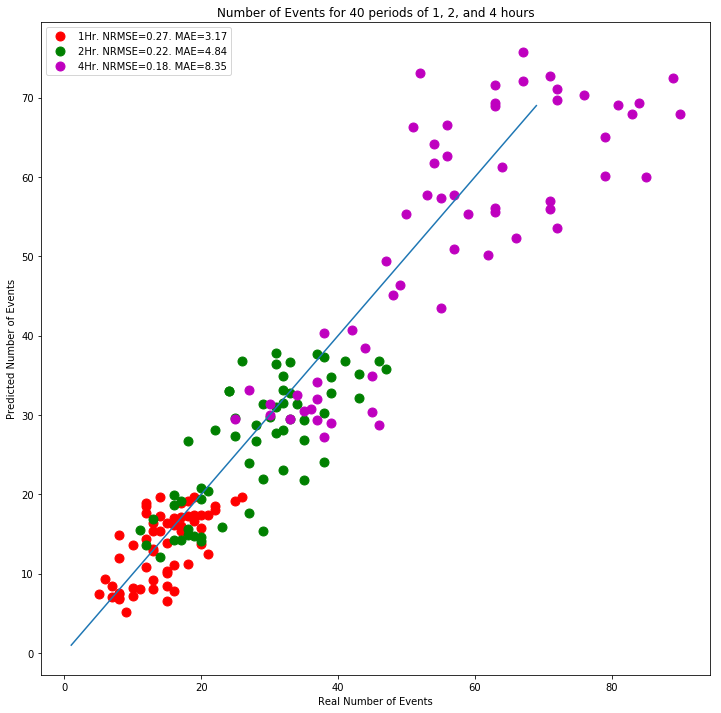

In [25]:
import sklearn.metrics
rmse1 = sqrt(sklearn.metrics.mean_squared_error(real_num_1h, pred_num_1h))/ (np.mean(real_num_1h))
rmse2 = sqrt(sklearn.metrics.mean_squared_error(real_num_2h, pred_num_2h))/(np.mean(real_num_2h))
rmse4 = sqrt(sklearn.metrics.mean_squared_error(real_num_4h, pred_num_4h))/(np.mean(real_num_4h))

mae1 = sklearn.metrics.mean_absolute_error(real_num_1h, pred_num_1h)
mae2 = sklearn.metrics.mean_absolute_error(real_num_2h, pred_num_2h)
mae4 = sklearn.metrics.mean_absolute_error(real_num_4h, pred_num_4h)

plt.figure(figsize=(12,12))
plt.plot(real_num_1h, pred_num_1h, 'r.', label = "1Hr. NRMSE="+str(round(rmse1, 2))+". MAE="+str(round(mae1, 2)), markersize=18)
plt.plot(real_num_2h, pred_num_2h, 'g.', label = "2Hr. NRMSE="+str(round(rmse2, 2))+". MAE="+str(round(mae2, 2)), markersize=18)
plt.plot(real_num_4h, pred_num_4h, 'm.', label = "4Hr. NRMSE="+str(round(rmse4, 2))+". MAE="+str(round(mae4, 2)), markersize=18)
plt.xlabel('Real Number of Events')
plt.ylabel('Predicted Number of Events')
plt.legend()
plt.title('Number of Events for 40 periods of 1, 2, and 4 hours')
x = np.arange(1, 70)
plt.plot(x, x)
#plt.plot(real_nm_24h, pred_num_24h, 'b.')


<Figure size 1440x720 with 0 Axes>

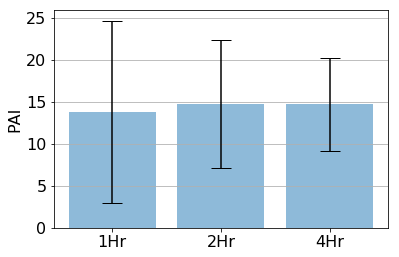

In [26]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(20,10))

labels=['1Hr',
      '2Hr', 
      '4Hr']
x_pos = np.arange(len(labels))
CTEs = [np.mean(pai_1h),
       np.mean(pai_2h), 
       np.mean(pai_4h)]

error = [np.std(pai_1h),
       np.std(pai_2h), 
       np.std(pai_4h)]

fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr = error,  alpha=0.5, ecolor='black', capsize=10)

ax.set_ylabel("PAI")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title("Average PAI for 20 predicions over 1, 2, and 4 hours \nfor 50 by 50 grid (cell size of .16 mi^2)")
ax.yaxis.grid(True)

plt.show()

#### What about peak time detection?

In [45]:
percentile = 80

In [46]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
simulation._LastTime

last_t = simulation._LastTime
indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*2: # 2 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_2h = []
real_num_2h = []
pai_2h = []
percentile_2h = []

for i in range(0, 300):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0)
    pred_num_2h.append(sum(sum(pred)))
    real_num_2h.append(sum(sum(real)))
    pai_2h.append(pai)
    percentile_2h.append(np.percentile(array(pred_num_2h), percentile))
    test_points.to_csv('for_results.csv')
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.0831367603 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 10.606060606060606. 
Hit number/Tot number: 0.09090909090909091. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.83530470700706

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.30031464075992226, Real: 1.0
Grid: (27, 24), Model: 0.28203387680367786, Real: 1.0
Grid: (28, 24), Model: 0.1433688985840923, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2986295108249763, Real: 0.0
Grid: (26, 22), Model: 0.28435056283023935, Real: 0.0
Grid: (28, 23), Model: 0.21285807907585838, Real: 0.0
Grid: (8, 38), Model: 0.19501030670933586, Real: 0.0
Grid: (14, 22), Model: 0.1876924627442602, Real: 0.0
Grid: (11, 35), Model: 0.16508897974901826, Real: 0.0
Grid: (26, 23), Model: 0.16018631038024214, Real: 0.0
Grid: (0, 31), Model: 0.15934210946422303, Real: 0.0
Grid: (33, 25), Model: 0.1588019035905190

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



Predicting over time of 0.0766784125 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 24.305555555555557. 
Hit number/Tot number: 0.20833333333333334. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.07980025652204

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.22139340373409044, Real: 1.0
Grid: (44, 32), Model: 0.1188450518006802, Real: 1.0
Grid: (35, 32), Model: 0.11713890590945505, Real: 1.0
Grid: (36, 24), Model: 0.11426136579074585, Real: 1.0
Grid: (33, 24), Model: 0.11247180461333078, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3095232173420535, Real: 0.0
Grid: (27, 23), Model: 0.3067411256255826, Real: 0.0
Grid: (27, 24), Model: 0.2892389544628313, Real: 0.0
Grid: (26, 22), Model: 0.2796910705316635, Real: 0.0
Grid: (8, 38), Model: 0.19562270235075155, Real: 0.0
Grid: (14, 22), Model: 0.18875392201523283, Real: 0.0
Grid: (11, 35), Model: 0.1660376736679871,


Predicting over time of 0.080555736 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 17.28395061728395. 
Hit number/Tot number: 0.14814814814814814. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 17.669292924913215

Predicted hotspots in real top 30
Grid: (28, 24), Model: 0.07571110869798282, Real: 1.0
Grid: (27, 26), Model: 0.07091791924594476, Real: 3.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.16526552297165, Real: 0.0
Grid: (27, 23), Model: 0.1641513566535354, Real: 0.0
Grid: (27, 24), Model: 0.1552375598227765, Real: 0.0
Grid: (26, 22), Model: 0.15039044381133307, Real: 0.0
Grid: (28, 23), Model: 0.11928564239833994, Real: 0.0
Grid: (8, 38), Model: 0.10451369260830647, Real: 0.0
Grid: (14, 22), Model: 0.10095744015439995, Real: 0.0
Grid: (11, 35), Model: 0.08881318565390171, Real: 0.0
Grid: (0, 31), Model: 0.08572157172810113, Real: 0.0
Grid: (26, 23), Model: 0.08267156560628652, 


Predicting over time of 0.080902959 days. Generating 8 intensity prediction(s)
0.0

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 24.001049095564227

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2268476021487845, Real: 0.0
Grid: (27, 23), Model: 0.2191031205606062, Real: 0.0
Grid: (26, 22), Model: 0.20952618833785305, Real: 0.0
Grid: (27, 24), Model: 0.20743582196931343, Real: 0.0
Grid: (28, 23), Model: 0.16327721361605047, Real: 0.0
Grid: (8, 38), Model: 0.14235711979263188, Real: 0.0
Grid: (14, 22), Model: 0.13764147775342184, Real: 0.0
Grid: (11, 35), Model: 0.12109490451125692, Real: 0.0
Grid: (0, 31), Model: 0.11687958490943767, Real: 0.0
Grid: (28, 24), Model: 0.11258682842109749, Real: 0.0
Grid: (33, 25), Model: 0.11170512058032753, Real: 0.0
Grid: (26, 23), Model: 0.11126573674384732, Real: 0.0
Grid: (27, 26), M


Predicting over time of 0.07870388 days. Generating 8 intensity prediction(s)
6.0

The predictive accuracy index for 30 hotspots is: 22.58064516129032. 
Hit number/Tot number: 0.1935483870967742. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 36.43012501268407

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.3366265917081633, Real: 1.0
Grid: (28, 23), Model: 0.24919455686663627, Real: 1.0
Grid: (29, 22), Model: 0.14546900459772388, Real: 2.0
Grid: (32, 25), Model: 0.14315346254611075, Real: 1.0
Grid: (44, 32), Model: 0.13043012107599755, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.32820763102857936, Real: 0.0
Grid: (26, 22), Model: 0.3173460794582237, Real: 0.0
Grid: (27, 24), Model: 0.31087398981174474, Real: 0.0
Grid: (8, 38), Model: 0.21532296274470578, Real: 0.0
Grid: (14, 22), Model: 0.20827647486405848, Real: 0.0
Grid: (11, 35), Model: 0.18324963906937608, Real: 0.0
Grid: (0, 31), Model: 0.17687074348084245, 


Predicting over time of 0.0708913625 days. Generating 7 intensity prediction(s)
6.0

The predictive accuracy index for 30 hotspots is: 27.999999999999996. 
Hit number/Tot number: 0.24. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 27.33323300623939

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.25155290418583653, Real: 1.0
Grid: (27, 23), Model: 0.24349143754555597, Real: 4.0
Grid: (32, 25), Model: 0.11447232207297106, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.23687339150407036, Real: 0.0
Grid: (27, 24), Model: 0.2343651143857478, Real: 0.0
Grid: (28, 23), Model: 0.18680423904403506, Real: 0.0
Grid: (8, 38), Model: 0.16092944506558216, Real: 0.0
Grid: (14, 22), Model: 0.15570747521112613, Real: 0.0
Grid: (11, 35), Model: 0.1370058330602225, Real: 0.0
Grid: (0, 31), Model: 0.1322367037836083, Real: 0.0
Grid: (26, 23), Model: 0.12930388079393723, Real: 0.0
Grid: (27, 26), Model: 0.1269750254620627, Real: 0.0
Gri


Predicting over time of 0.0799886051 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 11.666666666666666. 
Hit number/Tot number: 0.1. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.12775524000786

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.12007514436307949, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.13844630386786924, Real: 0.0
Grid: (27, 23), Model: 0.13396602425204063, Real: 0.0
Grid: (27, 24), Model: 0.11966228772390197, Real: 0.0
Grid: (28, 23), Model: 0.09463705927909401, Real: 0.0
Grid: (8, 38), Model: 0.08306443295225695, Real: 0.0
Grid: (14, 22), Model: 0.08038436483705685, Real: 0.0
Grid: (11, 35), Model: 0.0707338471156797, Real: 0.0
Grid: (26, 23), Model: 0.06832224872921788, Real: 0.0
Grid: (0, 31), Model: 0.0682716375299127, Real: 0.0
Grid: (33, 25), Model: 0.0677868631746356, Real: 0.0
Grid: (27, 26), Model: 0.06221282568895885, Real: 0.0
Gri

4.0

The predictive accuracy index for 30 hotspots is: 12.280701754385964. 
Hit number/Tot number: 0.10526315789473684. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 24.136642114064433

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.23479381320823467, Real: 2.0
Grid: (26, 22), Model: 0.21097386192585701, Real: 1.0
Grid: (26, 26), Model: 0.08036240260262226, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.22433612688492555, Real: 0.0
Grid: (27, 24), Model: 0.20363564548756247, Real: 0.0
Grid: (28, 23), Model: 0.16028130753807202, Real: 0.0
Grid: (8, 38), Model: 0.1424420371601819, Real: 0.0
Grid: (14, 22), Model: 0.1378632361099274, Real: 0.0
Grid: (11, 35), Model: 0.12131906979074261, Real: 0.0
Grid: (0, 31), Model: 0.11709603557456844, Real: 0.0
Grid: (26, 23), Model: 0.11433307142083293, Real: 0.0
Grid: (33, 25), Model: 0.1129656719486616, Real: 0.0
Grid: (27, 31), Model: 0.1041946727923719, Real: 0.0
Grid: (41, 16)


Predicting over time of 0.08200249849999999 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 17.676767676767675. 
Hit number/Tot number: 0.15151515151515152. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 36.70977301011243

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.31920271032920783, Real: 1.0
Grid: (27, 24), Model: 0.30641069538766963, Real: 1.0
Grid: (28, 23), Model: 0.24044821337782837, Real: 1.0
Grid: (36, 24), Model: 0.12932940135901091, Real: 1.0
Grid: (33, 24), Model: 0.12446804500254387, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3655367724533644, Real: 0.0
Grid: (27, 23), Model: 0.3340711161309042, Real: 0.0
Grid: (8, 38), Model: 0.2155947906026151, Real: 0.0
Grid: (14, 22), Model: 0.2086818850782669, Real: 0.0
Grid: (11, 35), Model: 0.1836495823433762, Real: 0.0
Grid: (0, 31), Model: 0.1772568977177683, Real: 0.0
Grid: (26, 23), Model: 0.170180700672


Predicting over time of 0.0827432409 days. Generating 8 intensity prediction(s)
8.0

The predictive accuracy index for 30 hotspots is: 26.666666666666664. 
Hit number/Tot number: 0.22857142857142856. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.41732171242359

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.2636659098715441, Real: 2.0
Grid: (26, 22), Model: 0.25527018568353566, Real: 1.0
Grid: (27, 24), Model: 0.25344887624368473, Real: 2.0
Grid: (33, 25), Model: 0.13202086213226125, Real: 1.0
Grid: (36, 24), Model: 0.11278246289206399, Real: 1.0
Grid: (29, 20), Model: 0.11130242013266448, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.28752101566719485, Real: 0.0
Grid: (28, 23), Model: 0.20120074327166393, Real: 0.0
Grid: (8, 38), Model: 0.17212150683695362, Real: 0.0
Grid: (14, 22), Model: 0.1666117303288212, Real: 0.0
Grid: (11, 35), Model: 0.14663416343428673, Real: 0.0
Grid: (0, 31), Model: 0.141529979522339


Predicting over time of 0.0816784237 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 21.21212121212121. 
Hit number/Tot number: 0.18181818181818182. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 15.498739513720055

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.14702237169051188, Real: 1.0
Grid: (36, 24), Model: 0.05941873825189758, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.14760483311132824, Real: 0.0
Grid: (27, 24), Model: 0.1359372367746649, Real: 0.0
Grid: (26, 22), Model: 0.1342094778645574, Real: 0.0
Grid: (28, 23), Model: 0.103714950789881, Real: 0.0
Grid: (8, 38), Model: 0.09113571234253817, Real: 0.0
Grid: (14, 22), Model: 0.08822215223574334, Real: 0.0
Grid: (11, 35), Model: 0.07764959060014405, Real: 0.0
Grid: (0, 31), Model: 0.07494670635676474, Real: 0.0
Grid: (33, 25), Model: 0.0710653392444319, Real: 0.0
Grid: (26, 23), Model: 0.07032349102755056,


Predicting over time of 0.08312518619999999 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 13.565891472868216. 
Hit number/Tot number: 0.11627906976744186. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.18797305378732

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.31587969257501386, Real: 1.0
Grid: (27, 23), Model: 0.2987097943542938, Real: 1.0
Grid: (28, 24), Model: 0.1332781967718044, Real: 1.0
Grid: (27, 26), Model: 0.13035779753852417, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.2768100268402179, Real: 0.0
Grid: (26, 22), Model: 0.27405013241860005, Real: 0.0
Grid: (28, 23), Model: 0.21240039497924232, Real: 0.0
Grid: (8, 38), Model: 0.1892283194126758, Real: 0.0
Grid: (14, 22), Model: 0.1831819723048318, Real: 0.0
Grid: (11, 35), Model: 0.16123891059192394, Real: 0.0
Grid: (0, 31), Model: 0.15562641747457115, Real: 0.0
Grid: (26, 23), Model: 0.15050798646


Predicting over time of 0.0817247201 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 15.350877192982454. 
Hit number/Tot number: 0.13157894736842105. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 30.207450310681402

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.2903750108802002, Real: 1.0
Grid: (27, 24), Model: 0.2667842246936013, Real: 1.0
Grid: (27, 31), Model: 0.1480633948457772, Real: 1.0
Grid: (32, 25), Model: 0.1186394868118151, Real: 1.0
Grid: (26, 27), Model: 0.10310136596244807, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2823454552271148, Real: 0.0
Grid: (26, 22), Model: 0.25206180715643905, Real: 0.0
Grid: (28, 23), Model: 0.20170677875397117, Real: 0.0
Grid: (8, 38), Model: 0.17596136004249724, Real: 0.0
Grid: (14, 22), Model: 0.17034001893387554, Real: 0.0
Grid: (11, 35), Model: 0.14994341869436384, Real: 0.0
Grid: (0, 31), Model: 0.14472413093426334


Predicting over time of 0.0771413765 days. Generating 8 intensity prediction(s)
1.0

The predictive accuracy index for 30 hotspots is: 6.862745098039215. 
Hit number/Tot number: 0.058823529411764705. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 19.22016116523738

Predicted hotspots in real top 30
Grid: (26, 23), Model: 0.08886805443841109, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.19788896321563879, Real: 0.0
Grid: (27, 23), Model: 0.17532482226573495, Real: 0.0
Grid: (27, 24), Model: 0.16915223150600586, Real: 0.0
Grid: (26, 22), Model: 0.15843997161953433, Real: 0.0
Grid: (28, 23), Model: 0.12572498344301036, Real: 0.0
Grid: (8, 38), Model: 0.11150830040917388, Real: 0.0
Grid: (14, 22), Model: 0.10794595724189354, Real: 0.0
Grid: (27, 31), Model: 0.09823782140621778, Real: 0.0
Grid: (11, 35), Model: 0.09502557247122505, Real: 0.0
Grid: (0, 31), Model: 0.09171790219955392, Real: 0.0
Grid: (33, 25), Model: 0.0887599885985


Predicting over time of 0.078125175 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 17.5. 
Hit number/Tot number: 0.15. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 19.360723952650172

Predicted hotspots in real top 30
Grid: (27, 31), Model: 0.09421866889663974, Real: 1.0
Grid: (29, 22), Model: 0.07787791396855791, Real: 1.0
Grid: (34, 24), Model: 0.07690067995351352, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.19194192122100218, Real: 0.0
Grid: (27, 23), Model: 0.17906605049426186, Real: 0.0
Grid: (27, 24), Model: 0.16753217505988932, Real: 0.0
Grid: (26, 22), Model: 0.15968680887825523, Real: 0.0
Grid: (28, 23), Model: 0.1260375342766744, Real: 0.0
Grid: (8, 38), Model: 0.11313349989548566, Real: 0.0
Grid: (14, 22), Model: 0.10951858128492845, Real: 0.0
Grid: (11, 35), Model: 0.09641541311811955, Real: 0.0
Grid: (0, 31), Model: 0.09305938216993175, Real: 0.0
Grid: (26, 23)


Predicting over time of 0.0830788898 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 15.350877192982454. 
Hit number/Tot number: 0.13157894736842105. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 37.25778696671954

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.3582297613864922, Real: 2.0
Grid: (33, 25), Model: 0.1731562588572098, Real: 1.0
Grid: (27, 26), Model: 0.16371912122085874, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.3631196954210466, Real: 0.0
Grid: (27, 24), Model: 0.34506919017411525, Real: 0.0
Grid: (26, 22), Model: 0.31246171667699807, Real: 0.0
Grid: (28, 23), Model: 0.2400928619332126, Real: 0.0
Grid: (8, 38), Model: 0.2172437831936152, Real: 0.0
Grid: (14, 22), Model: 0.21030026917331743, Real: 0.0
Grid: (11, 35), Model: 0.18514901945338513, Real: 0.0
Grid: (27, 31), Model: 0.18127797510804206, Real: 0.0
Grid: (0, 31), Model: 0.17870437701599975,


Predicting over time of 0.0808913849 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 12.068965517241379. 
Hit number/Tot number: 0.10344827586206896. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 31.37252831839961

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.20019707837872175, Real: 1.0
Grid: (27, 26), Model: 0.13845558743697695, Real: 1.0
Grid: (29, 20), Model: 0.11691440902295011, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3130635075861873, Real: 0.0
Grid: (27, 23), Model: 0.2948556441466682, Real: 0.0
Grid: (27, 24), Model: 0.2789110458780089, Real: 0.0
Grid: (26, 22), Model: 0.26620326228004765, Real: 0.0
Grid: (8, 38), Model: 0.1822501273574456, Real: 0.0
Grid: (14, 22), Model: 0.17642287198618165, Real: 0.0
Grid: (11, 35), Model: 0.15533153838802527, Real: 0.0
Grid: (27, 31), Model: 0.15424151352024162, Real: 0.0
Grid: (0, 31), Model: 0.14992480504835318


Predicting over time of 0.08033582809999999 days. Generating 8 intensity prediction(s)
0.0

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 15.842343912366811

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.1530495919184037, Real: 0.0
Grid: (27, 23), Model: 0.14902357123320703, Real: 0.0
Grid: (27, 24), Model: 0.13736475210520885, Real: 0.0
Grid: (26, 22), Model: 0.13188711973254158, Real: 0.0
Grid: (28, 23), Model: 0.10325978151639881, Real: 0.0
Grid: (8, 38), Model: 0.09210454083718594, Real: 0.0
Grid: (14, 22), Model: 0.08915822849691668, Real: 0.0
Grid: (11, 35), Model: 0.07850371529199154, Real: 0.0
Grid: (0, 31), Model: 0.07577119537632776, Real: 0.0
Grid: (27, 31), Model: 0.07495536384517792, Real: 0.0
Grid: (27, 26), Model: 0.07430789205728076, Real: 0.0
Grid: (33, 25), Model: 0.07247109884220242, Real: 0.0
Grid: (2


Predicting over time of 0.0796761044 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 18.229166666666664. 
Hit number/Tot number: 0.15625. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 23.016765614679233

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.21749770238548144, Real: 1.0
Grid: (27, 24), Model: 0.20187237119992912, Real: 2.0
Grid: (27, 31), Model: 0.11114949654781678, Real: 1.0
Grid: (28, 24), Model: 0.09715305000697373, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.22281155075556425, Real: 0.0
Grid: (26, 22), Model: 0.1950325682400816, Real: 0.0
Grid: (28, 23), Model: 0.14877478657154525, Real: 0.0
Grid: (8, 38), Model: 0.13440830839135037, Real: 0.0
Grid: (14, 22), Model: 0.13010662246601032, Real: 0.0
Grid: (11, 35), Model: 0.11456476905079482, Real: 0.0
Grid: (0, 31), Model: 0.1105770722652905, Real: 0.0
Grid: (33, 25), Model: 0.1038309424727646, Real: 0.


Predicting over time of 0.0824654625 days. Generating 8 intensity prediction(s)
6.0

The predictive accuracy index for 30 hotspots is: 16.27906976744186. 
Hit number/Tot number: 0.13953488372093023. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.14501880461524

Predicted hotspots in real top 30
Grid: (28, 24), Model: 0.15136670073395148, Real: 1.0
Grid: (26, 32), Model: 0.13868307008288344, Real: 1.0
Grid: (32, 25), Model: 0.13485207828208334, Real: 3.0
Grid: (26, 26), Model: 0.1180474256103011, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.33636518145722627, Real: 0.0
Grid: (27, 22), Model: 0.33184848803780403, Real: 0.0
Grid: (27, 24), Model: 0.3201118422976743, Real: 0.0
Grid: (26, 22), Model: 0.29145770271156346, Real: 0.0
Grid: (28, 23), Model: 0.22436154235188313, Real: 0.0
Grid: (8, 38), Model: 0.20454521836731496, Real: 0.0
Grid: (14, 22), Model: 0.197995272599297, Real: 0.0
Grid: (11, 35), Model: 0.1743531409557511,


Predicting over time of 0.08273166679999999 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 10.144927536231883. 
Hit number/Tot number: 0.08695652173913043. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 31.0106322006678

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.3075930141577295, Real: 1.0
Grid: (27, 26), Model: 0.12954031488687046, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.28555068198060796, Real: 0.0
Grid: (27, 24), Model: 0.2711889410146031, Real: 0.0
Grid: (26, 22), Model: 0.265024671729127, Real: 0.0
Grid: (28, 23), Model: 0.19464396434160225, Real: 0.0
Grid: (8, 38), Model: 0.17858835741788923, Real: 0.0
Grid: (14, 22), Model: 0.17286644973074156, Real: 0.0
Grid: (11, 35), Model: 0.1522327267713371, Real: 0.0
Grid: (32, 25), Model: 0.1470264835249329, Real: 0.0
Grid: (0, 31), Model: 0.14693395855339167, Real: 0.0
Grid: (27, 31), Model: 0.1442374713814


Predicting over time of 0.08312518619999999 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 21.875. 
Hit number/Tot number: 0.1875. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 13.10936717863799

Predicted hotspots in real top 30
Grid: (27, 31), Model: 0.06258987376722058, Real: 2.0
Grid: (27, 26), Model: 0.0561568343457701, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.12992204857677875, Real: 0.0
Grid: (27, 22), Model: 0.12209752308607405, Real: 0.0
Grid: (26, 22), Model: 0.11540668194446088, Real: 0.0
Grid: (27, 24), Model: 0.11264641216711287, Real: 0.0
Grid: (28, 23), Model: 0.08242068975698537, Real: 0.0
Grid: (8, 38), Model: 0.07609647004388746, Real: 0.0
Grid: (14, 22), Model: 0.0736565202555794, Real: 0.0
Grid: (11, 35), Model: 0.06486910030162187, Real: 0.0
Grid: (0, 31), Model: 0.06261121383253714, Real: 0.0
Grid: (26, 23), Model: 0.05896104975121456, Real: 0.0
Grid


Predicting over time of 0.0803705504 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 9.210526315789473. 
Hit number/Tot number: 0.07894736842105263. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.773296382226263

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.3135008107145468, Real: 1.0
Grid: (26, 22), Model: 0.2714108077972371, Real: 1.0
Grid: (27, 26), Model: 0.1308669944595931, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.27369912297997867, Real: 0.0
Grid: (27, 24), Model: 0.25266136963862135, Real: 0.0
Grid: (28, 23), Model: 0.1864873865598601, Real: 0.0
Grid: (8, 38), Model: 0.1728083687649687, Real: 0.0
Grid: (14, 22), Model: 0.16726427021133786, Real: 0.0
Grid: (27, 31), Model: 0.15758931406550378, Real: 0.0
Grid: (11, 35), Model: 0.1473165259713402, Real: 0.0
Grid: (0, 31), Model: 0.1421889308004281, Real: 0.0
Grid: (26, 23), Model: 0.13240449396690396, R


Predicting over time of 0.0828358337 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 8.974358974358974. 
Hit number/Tot number: 0.07692307692307693. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.70100982989777

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.32628244204340745, Real: 1.0
Grid: (27, 22), Model: 0.3223174068369569, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.371887488211372, Real: 0.0
Grid: (27, 24), Model: 0.2976949229974743, Real: 0.0
Grid: (28, 23), Model: 0.22805732374252505, Real: 0.0
Grid: (8, 38), Model: 0.20547695197778684, Real: 0.0
Grid: (14, 22), Model: 0.19888086334293614, Real: 0.0
Grid: (27, 31), Model: 0.17776918176950654, Real: 0.0
Grid: (11, 35), Model: 0.17517135758448948, Real: 0.0
Grid: (0, 31), Model: 0.16907425680746177, Real: 0.0
Grid: (27, 26), Model: 0.15836241250626065, Real: 0.0
Grid: (26, 23), Model: 0.15614361659539658,


Predicting over time of 0.0827085186 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 20.289855072463766. 
Hit number/Tot number: 0.17391304347826086. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 23.017310489317673

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.20508496649728974, Real: 2.0
Grid: (27, 26), Model: 0.09809021763205734, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2272085779024811, Real: 0.0
Grid: (27, 22), Model: 0.20908107143902327, Real: 0.0
Grid: (27, 24), Model: 0.18924006421530012, Real: 0.0
Grid: (28, 23), Model: 0.14372143834582832, Real: 0.0
Grid: (8, 38), Model: 0.13151687345005159, Real: 0.0
Grid: (14, 22), Model: 0.12729249729456676, Real: 0.0
Grid: (11, 35), Model: 0.11212292823746593, Real: 0.0
Grid: (27, 31), Model: 0.10985012530589541, Real: 0.0
Grid: (0, 31), Model: 0.10822033981915208, Real: 0.0
Grid: (26, 23), Model: 0.1044710710981


Predicting over time of 0.0808798108 days. Generating 8 intensity prediction(s)
6.0

The predictive accuracy index for 30 hotspots is: 24.999999999999996. 
Hit number/Tot number: 0.21428571428571427. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 21.451252190807676

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.21080192264858255, Real: 1.0
Grid: (27, 24), Model: 0.17739855060724372, Real: 1.0
Grid: (28, 23), Model: 0.1387764293850026, Real: 1.0
Grid: (26, 23), Model: 0.09593291925866818, Real: 1.0
Grid: (28, 24), Model: 0.0927272437221212, Real: 1.0
Grid: (35, 23), Model: 0.07296284003050453, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.19808402787905122, Real: 0.0
Grid: (26, 22), Model: 0.1928944568008659, Real: 0.0
Grid: (8, 38), Model: 0.1241623843331628, Real: 0.0
Grid: (14, 22), Model: 0.12017102666535714, Real: 0.0
Grid: (11, 35), Model: 0.10585715155573137, Real: 0.0
Grid: (27, 31), Model: 0.104998685362482


Predicting over time of 0.0810418482 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 8.333333333333332. 
Hit number/Tot number: 0.07142857142857142. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.28893657642348

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.3003457809089884, Real: 1.0
Grid: (28, 23), Model: 0.22949658628168304, Real: 1.0
Grid: (27, 31), Model: 0.1744874926557622, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.35847894392505664, Real: 0.0
Grid: (27, 22), Model: 0.3268991730271565, Real: 0.0
Grid: (26, 22), Model: 0.3131288813920367, Real: 0.0
Grid: (8, 38), Model: 0.20312222195509727, Real: 0.0
Grid: (14, 22), Model: 0.1965886116408101, Real: 0.0
Grid: (11, 35), Model: 0.17318107630352556, Real: 0.0
Grid: (0, 31), Model: 0.16715334110045937, Real: 0.0
Grid: (33, 25), Model: 0.1658017585878439, Real: 0.0
Grid: (28, 24), Model: 0.16332410520371277, R


Predicting over time of 0.0806599029 days. Generating 8 intensity prediction(s)
8.0

The predictive accuracy index for 30 hotspots is: 25.225225225225227. 
Hit number/Tot number: 0.21621621621621623. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.18082915775261

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.314028566734167, Real: 1.0
Grid: (26, 22), Model: 0.3018081908082309, Real: 2.0
Grid: (33, 25), Model: 0.14911174463125657, Real: 2.0
Grid: (26, 23), Model: 0.14727675477624858, Real: 1.0
Grid: (29, 20), Model: 0.11883134918988913, Real: 1.0
Grid: (32, 23), Model: 0.11363875261616878, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.32239829412729654, Real: 0.0
Grid: (27, 24), Model: 0.2813766706855318, Real: 0.0
Grid: (28, 23), Model: 0.23429554081289644, Real: 0.0
Grid: (8, 38), Model: 0.189271674819597, Real: 0.0
Grid: (14, 22), Model: 0.1831800593716814, Real: 0.0
Grid: (27, 31), Model: 0.16431193755899332, 


Predicting over time of 0.0753242428 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 20.58823529411765. 
Hit number/Tot number: 0.17647058823529413. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.80539876966089

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.13957922293213632, Real: 1.0
Grid: (28, 24), Model: 0.0634441938463914, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.14413776977498813, Real: 0.0
Grid: (26, 22), Model: 0.13639323107145077, Real: 0.0
Grid: (27, 24), Model: 0.12335057671454507, Real: 0.0
Grid: (28, 23), Model: 0.09987507142622166, Real: 0.0
Grid: (8, 38), Model: 0.0845480189650758, Real: 0.0
Grid: (14, 22), Model: 0.08182524525747877, Real: 0.0
Grid: (11, 35), Model: 0.07208931048353623, Real: 0.0
Grid: (26, 23), Model: 0.07194175125235854, Real: 0.0
Grid: (33, 25), Model: 0.07136415574805437, Real: 0.0
Grid: (27, 31), Model: 0.070957120945290


Predicting over time of 0.0826622222 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 18.666666666666668. 
Hit number/Tot number: 0.16. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 24.701354739335603

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.23637996797737706, Real: 2.0
Grid: (27, 24), Model: 0.2049197955596555, Real: 1.0
Grid: (26, 29), Model: 0.08905346177201745, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.23432095905662612, Real: 0.0
Grid: (26, 22), Model: 0.22048949504540147, Real: 0.0
Grid: (28, 23), Model: 0.1629556631559352, Real: 0.0
Grid: (8, 38), Model: 0.14227810139521466, Real: 0.0
Grid: (14, 22), Model: 0.13769344693517743, Real: 0.0
Grid: (11, 35), Model: 0.12131591970459134, Real: 0.0
Grid: (0, 31), Model: 0.11709345675940139, Real: 0.0
Grid: (27, 31), Model: 0.11671029947903942, Real: 0.0
Grid: (26, 23), Model: 0.11613871201580424, Real: 0.0



Predicting over time of 0.08185203519999999 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 12.612612612612613. 
Hit number/Tot number: 0.10810810810810811. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 36.872393305772974

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.3179932283854202, Real: 1.0
Grid: (34, 24), Model: 0.14752867701725147, Real: 1.0
Grid: (29, 20), Model: 0.13905972610178902, Real: 1.0
Grid: (37, 23), Model: 0.13562332933454496, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.36002017000973535, Real: 0.0
Grid: (27, 22), Model: 0.3405703020562665, Real: 0.0
Grid: (26, 22), Model: 0.31946515700197925, Real: 0.0
Grid: (28, 23), Model: 0.23763154302287864, Real: 0.0
Grid: (8, 38), Model: 0.21183649444676508, Real: 0.0
Grid: (14, 22), Model: 0.20500632240176747, Real: 0.0
Grid: (28, 24), Model: 0.18200876662934057, Real: 0.0
Grid: (11, 35), Model: 0.180631


Predicting over time of 0.0816552755 days. Generating 8 intensity prediction(s)
7.0

The predictive accuracy index for 30 hotspots is: 19.444444444444443. 
Hit number/Tot number: 0.16666666666666666. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.18481702479782

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.2940853625377026, Real: 1.0
Grid: (27, 22), Model: 0.29005681755299, Real: 2.0
Grid: (28, 23), Model: 0.20286618529454817, Real: 1.0
Grid: (37, 23), Model: 0.12830529552495085, Real: 1.0
Grid: (35, 32), Model: 0.10874265228463481, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.3111825778120818, Real: 0.0
Grid: (27, 24), Model: 0.27494727770696453, Real: 0.0
Grid: (8, 38), Model: 0.18340841628620302, Real: 0.0
Grid: (14, 22), Model: 0.17749128828679067, Real: 0.0
Grid: (11, 35), Model: 0.156395242954585, Real: 0.0
Grid: (0, 31), Model: 0.1509518739765732, Real: 0.0
Grid: (28, 24), Model: 0.14893092418176018, Re


Predicting over time of 0.0808450885 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 12.280701754385964. 
Hit number/Tot number: 0.10526315789473684. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 13.271241689240586

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.12628907784949842, Real: 1.0
Grid: (27, 26), Model: 0.059076979532187275, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.12800836324893236, Real: 0.0
Grid: (26, 22), Model: 0.11927303988931967, Real: 0.0
Grid: (27, 24), Model: 0.11081714749694145, Real: 0.0
Grid: (28, 23), Model: 0.08787006173582461, Real: 0.0
Grid: (8, 38), Model: 0.07555977469129757, Real: 0.0
Grid: (14, 22), Model: 0.07312060661745055, Real: 0.0
Grid: (11, 35), Model: 0.06443280640019355, Real: 0.0
Grid: (0, 31), Model: 0.062190218915117175, Real: 0.0
Grid: (27, 31), Model: 0.05981700344587326, Real: 0.0
Grid: (28, 24), Model: 0.0590966221


Predicting over time of 0.0767594312 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 16.203703703703702. 
Hit number/Tot number: 0.1388888888888889. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 31.43411848185382

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.27366741190628935, Real: 1.0
Grid: (33, 25), Model: 0.14456185772088345, Real: 1.0
Grid: (26, 23), Model: 0.13708742591532513, Real: 1.0
Grid: (32, 25), Model: 0.12073432039567439, Real: 1.0
Grid: (19, 24), Model: 0.10435742208030974, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.3043917025954944, Real: 0.0
Grid: (27, 22), Model: 0.29668980287131885, Real: 0.0
Grid: (27, 24), Model: 0.2671224913807862, Real: 0.0
Grid: (28, 23), Model: 0.20299326068660348, Real: 0.0
Grid: (8, 38), Model: 0.18032634662203254, Real: 0.0
Grid: (14, 22), Model: 0.17450063159485882, Real: 0.0
Grid: (27, 31), Model: 0.155500555482383


Predicting over time of 0.0825812035 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 13.72549019607843. 
Hit number/Tot number: 0.11764705882352941. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.34562892600699

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.21800112723494944, Real: 1.0
Grid: (33, 25), Model: 0.1545493953189635, Real: 2.0
Grid: (44, 32), Model: 0.12202251355162924, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.32117411959697106, Real: 0.0
Grid: (27, 22), Model: 0.30461123078578334, Real: 0.0
Grid: (26, 22), Model: 0.29612667113970104, Real: 0.0
Grid: (27, 24), Model: 0.2753141541628763, Real: 0.0
Grid: (49, 49), Model: 0.19564845790495225, Real: 0.0
Grid: (8, 38), Model: 0.18943190660312842, Real: 0.0
Grid: (14, 22), Model: 0.1833085415803428, Real: 0.0
Grid: (11, 35), Model: 0.161546226694979, Real: 0.0
Grid: (27, 31), Model: 0.1577950575010975, 


Predicting over time of 0.0720719207 days. Generating 7 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 27.45098039215686. 
Hit number/Tot number: 0.23529411764705882. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 17.1373440430824

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.16131778551086368, Real: 1.0
Grid: (27, 22), Model: 0.15417165370767333, Real: 1.0
Grid: (27, 31), Model: 0.08421049250776774, Real: 1.0
Grid: (34, 24), Model: 0.06608395959123119, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.1480991954038387, Real: 0.0
Grid: (27, 24), Model: 0.1431910653213772, Real: 0.0
Grid: (28, 23), Model: 0.1129670571472303, Real: 0.0
Grid: (49, 49), Model: 0.09962477925730362, Real: 0.0
Grid: (8, 38), Model: 0.09741350373294488, Real: 0.0
Grid: (14, 22), Model: 0.09426283970996996, Real: 0.0
Grid: (33, 25), Model: 0.08403958944072999, Real: 0.0
Grid: (11, 35), Model: 0.08307575345245231


Predicting over time of 0.0819793503 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 14.583333333333332. 
Hit number/Tot number: 0.125. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 23.828229219594895

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.20296329572327776, Real: 1.0
Grid: (34, 24), Model: 0.09621956383337657, Real: 1.0
Grid: (29, 22), Model: 0.08788860202512662, Real: 1.0
Grid: (19, 24), Model: 0.08239133530472603, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2263346861272547, Real: 0.0
Grid: (27, 22), Model: 0.22190265803861953, Real: 0.0
Grid: (27, 24), Model: 0.19677519553614037, Real: 0.0
Grid: (28, 23), Model: 0.15881185791956026, Real: 0.0
Grid: (49, 49), Model: 0.13880948560599268, Real: 0.0
Grid: (8, 38), Model: 0.13679012834006396, Real: 0.0
Grid: (14, 22), Model: 0.13236251908197633, Real: 0.0
Grid: (27, 31), Model: 0.11768020039844815, Real: 0


Predicting over time of 0.0828474078 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 15.350877192982454. 
Hit number/Tot number: 0.13157894736842105. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 36.17628429924447

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.2341602949112834, Real: 1.0
Grid: (27, 31), Model: 0.17944616564523735, Real: 1.0
Grid: (29, 22), Model: 0.15356883984236153, Real: 1.0
Grid: (34, 24), Model: 0.14912145290637258, Real: 1.0
Grid: (19, 24), Model: 0.12575665301618927, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.33617254044866235, Real: 0.0
Grid: (27, 22), Model: 0.3283768905214255, Real: 0.0
Grid: (26, 22), Model: 0.3084696627823004, Real: 0.0
Grid: (27, 24), Model: 0.3011925488806496, Real: 0.0
Grid: (49, 49), Model: 0.20879688499269, Real: 0.0
Grid: (8, 38), Model: 0.20642850951071082, Real: 0.0
Grid: (14, 22), Model: 0.19974322808480025, 

5.0

The predictive accuracy index for 30 hotspots is: 17.676767676767675. 
Hit number/Tot number: 0.15151515151515152. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.28766368250223

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.2798535537170528, Real: 1.0
Grid: (28, 23), Model: 0.21747183222257405, Real: 1.0
Grid: (29, 20), Model: 0.12086888628134496, Real: 1.0
Grid: (26, 32), Model: 0.11814320532144182, Real: 1.0
Grid: (19, 24), Model: 0.11605192164576839, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.30604191803320124, Real: 0.0
Grid: (27, 22), Model: 0.3036508442696161, Real: 0.0
Grid: (27, 24), Model: 0.27298448760063543, Real: 0.0
Grid: (49, 49), Model: 0.19185649895151713, Real: 0.0
Grid: (8, 38), Model: 0.19008305978743878, Real: 0.0
Grid: (14, 22), Model: 0.18392378072566062, Real: 0.0
Grid: (27, 31), Model: 0.17259362778134807, Real: 0.0
Grid: (11, 35), Model: 0.16211973364044138, Real: 0.0
Grid: (0, 31


Predicting over time of 0.08263907399999999 days. Generating 8 intensity prediction(s)
1.0

The predictive accuracy index for 30 hotspots is: 8.974358974358974. 
Hit number/Tot number: 0.07692307692307693. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.357541522949044

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.1248141684798719, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.1413412130547232, Real: 0.0
Grid: (27, 22), Model: 0.13231947724347465, Real: 0.0
Grid: (26, 22), Model: 0.12235360728091516, Real: 0.0
Grid: (28, 23), Model: 0.09824477082473665, Real: 0.0
Grid: (49, 49), Model: 0.08317112117307461, Real: 0.0
Grid: (8, 38), Model: 0.08254563553868688, Real: 0.0
Grid: (14, 22), Model: 0.07986896520346368, Real: 0.0
Grid: (27, 31), Model: 0.07101655214931797, Real: 0.0
Grid: (11, 35), Model: 0.07040462485011825, Real: 0.0
Grid: (0, 31), Model: 0.06795426784715713, Real: 0.0
Grid: (33, 25), Model: 0.06533769


Predicting over time of 0.0799538828 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 8.333333333333332. 
Hit number/Tot number: 0.07142857142857142. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.28863636337854

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.3258074594767016, Real: 2.0
Grid: (27, 26), Model: 0.14173761674297491, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.30076984437108983, Real: 0.0
Grid: (27, 24), Model: 0.2883570373300095, Real: 0.0
Grid: (26, 22), Model: 0.2792342685995651, Real: 0.0
Grid: (28, 23), Model: 0.22061795293904912, Real: 0.0
Grid: (49, 49), Model: 0.19238082624518257, Real: 0.0
Grid: (8, 38), Model: 0.19109384466032323, Real: 0.0
Grid: (14, 22), Model: 0.18489381297469037, Real: 0.0
Grid: (11, 35), Model: 0.16299160111435188, Real: 0.0
Grid: (27, 31), Model: 0.16006279257511874, Real: 0.0
Grid: (0, 31), Model: 0.15731887771317016


Predicting over time of 0.0829747229 days. Generating 8 intensity prediction(s)
7.0

The predictive accuracy index for 30 hotspots is: 30.24691358024691. 
Hit number/Tot number: 0.25925925925925924. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.6160855549872

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.32506768732688074, Real: 1.0
Grid: (27, 24), Model: 0.28926778187410285, Real: 1.0
Grid: (26, 22), Model: 0.27354892420164467, Real: 1.0
Grid: (27, 31), Model: 0.15770878138129144, Real: 2.0
Grid: (33, 25), Model: 0.15419945210046992, Real: 1.0
Grid: (26, 32), Model: 0.1222535586176469, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3084966332990964, Real: 0.0
Grid: (28, 23), Model: 0.21744310122992083, Real: 0.0
Grid: (49, 49), Model: 0.18526734940449893, Real: 0.0
Grid: (8, 38), Model: 0.18417274444026976, Real: 0.0
Grid: (14, 22), Model: 0.1781919583637641, Real: 0.0
Grid: (26, 23), Model: 0.16623645886818292


Predicting over time of 0.0831599085 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 21.875. 
Hit number/Tot number: 0.1875. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 13.143703718839408

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.12082935767054363, Real: 1.0
Grid: (27, 31), Model: 0.06847582544093826, Real: 1.0
Grid: (33, 25), Model: 0.06695403415974213, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.13400837366547308, Real: 0.0
Grid: (27, 24), Model: 0.1156318980490526, Real: 0.0
Grid: (26, 22), Model: 0.11178912316093267, Real: 0.0
Grid: (28, 23), Model: 0.08563210622944867, Real: 0.0
Grid: (49, 49), Model: 0.07477689535621605, Real: 0.0
Grid: (8, 38), Model: 0.07435650904069359, Real: 0.0
Grid: (14, 22), Model: 0.07194058789294007, Real: 0.0
Grid: (26, 23), Model: 0.06751467361982944, Real: 0.0
Grid: (11, 35), Model: 0.06342583491110051, Real: 0.0
Grid: (0


Predicting over time of 0.082060369 days. Generating 8 intensity prediction(s)
6.0

The predictive accuracy index for 30 hotspots is: 20.0. 
Hit number/Tot number: 0.17142857142857143. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 30.810491280004097

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.2574302391115313, Real: 1.0
Grid: (33, 25), Model: 0.15647455175586772, Real: 1.0
Grid: (29, 20), Model: 0.11909816044439024, Real: 1.0
Grid: (35, 32), Model: 0.11098717801638878, Real: 1.0
Grid: (33, 24), Model: 0.10774106159942591, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.3024756805225203, Real: 0.0
Grid: (27, 22), Model: 0.2854690938345834, Real: 0.0
Grid: (27, 24), Model: 0.2629727278827902, Real: 0.0
Grid: (28, 23), Model: 0.205580326122193, Real: 0.0
Grid: (49, 49), Model: 0.17594372960538962, Real: 0.0
Grid: (8, 38), Model: 0.17499183995143644, Real: 0.0
Grid: (14, 22), Model: 0.16930300834714973, Real: 0.0
Gri


Predicting over time of 0.0807987921 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 16.666666666666664. 
Hit number/Tot number: 0.14285714285714285. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 37.9046746462657

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.3597552952284506, Real: 1.0
Grid: (26, 22), Model: 0.32682776700807425, Real: 1.0
Grid: (33, 25), Model: 0.18924583354818317, Real: 1.0
Grid: (26, 23), Model: 0.1760368855120748, Real: 1.0
Grid: (33, 24), Model: 0.1413240816772941, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3408846551776299, Real: 0.0
Grid: (27, 24), Model: 0.31424248214618555, Real: 0.0
Grid: (28, 23), Model: 0.2549320121271552, Real: 0.0
Grid: (49, 49), Model: 0.21478495177491036, Real: 0.0
Grid: (8, 38), Model: 0.2136534496199472, Real: 0.0
Grid: (14, 22), Model: 0.2067041649536469, Real: 0.0
Grid: (27, 31), Model: 0.18849698708611895, R


Predicting over time of 0.0830673157 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 15.909090909090907. 
Hit number/Tot number: 0.13636363636363635. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 26.788947622545034

Predicted hotspots in real top 30
Grid: (26, 23), Model: 0.1265346076424122, Real: 1.0
Grid: (27, 26), Model: 0.12004277428152801, Real: 1.0
Grid: (34, 24), Model: 0.11085982384004593, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.26065464993371673, Real: 0.0
Grid: (27, 22), Model: 0.24304207904808697, Real: 0.0
Grid: (26, 22), Model: 0.23038801722795643, Real: 0.0
Grid: (27, 24), Model: 0.21875236026726522, Real: 0.0
Grid: (28, 23), Model: 0.18150268106956996, Real: 0.0
Grid: (49, 49), Model: 0.15174098782077558, Real: 0.0
Grid: (8, 38), Model: 0.15095746335986363, Real: 0.0
Grid: (14, 22), Model: 0.14604490875456663, Real: 0.0
Grid: (33, 25), Model: 0.133163956785


Predicting over time of 0.0830673157 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 9.333333333333334. 
Hit number/Tot number: 0.08. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 20.23448095258328

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.19243121472646718, Real: 1.0
Grid: (26, 22), Model: 0.17041511097833495, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.18981184119732078, Real: 0.0
Grid: (27, 24), Model: 0.16461153346609345, Real: 0.0
Grid: (28, 23), Model: 0.1333988787832161, Real: 0.0
Grid: (49, 49), Model: 0.11573062590611302, Real: 0.0
Grid: (8, 38), Model: 0.1151446717977096, Real: 0.0
Grid: (14, 22), Model: 0.1113950127671914, Real: 0.0
Grid: (11, 35), Model: 0.0982283564916137, Real: 0.0
Grid: (26, 23), Model: 0.09717571099484937, Real: 0.0
Grid: (33, 25), Model: 0.09641895818310406, Real: 0.0
Grid: (27, 31), Model: 0.09609278361587788, Real: 0.0
Gri


Predicting over time of 0.0815626827 days. Generating 8 intensity prediction(s)
1.0

The predictive accuracy index for 30 hotspots is: 2.9166666666666665. 
Hit number/Tot number: 0.025. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.62771666499643

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.3393121112542185, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.3382651450014199, Real: 0.0
Grid: (26, 22), Model: 0.30041104068831437, Real: 0.0
Grid: (27, 24), Model: 0.29398493971330086, Real: 0.0
Grid: (28, 23), Model: 0.2291705781967966, Real: 0.0
Grid: (49, 49), Model: 0.20243881821055995, Real: 0.0
Grid: (8, 38), Model: 0.20142533958128872, Real: 0.0
Grid: (14, 22), Model: 0.19486254495551922, Real: 0.0
Grid: (11, 35), Model: 0.1718374062977832, Real: 0.0
Grid: (27, 31), Model: 0.16587842426869384, Real: 0.0
Grid: (0, 31), Model: 0.16585699881555735, Real: 0.0
Grid: (26, 23), Model: 0.1646681330609487, Real: 0.0
Gri


Predicting over time of 0.08160897909999999 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 13.999999999999998. 
Hit number/Tot number: 0.12. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 20.59683049008594

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.1733456951004842, Real: 1.0
Grid: (28, 23), Model: 0.13349029375878396, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.20387239011660266, Real: 0.0
Grid: (27, 22), Model: 0.18917492960377308, Real: 0.0
Grid: (27, 24), Model: 0.16811540990007273, Real: 0.0
Grid: (49, 49), Model: 0.11626620029516697, Real: 0.0
Grid: (8, 38), Model: 0.11569177876890203, Real: 0.0
Grid: (14, 22), Model: 0.11191921541752266, Real: 0.0
Grid: (11, 35), Model: 0.09870129840415721, Real: 0.0
Grid: (27, 31), Model: 0.09679590115885878, Real: 0.0
Grid: (0, 31), Model: 0.09526624645386099, Real: 0.0
Grid: (33, 25), Model: 0.0951543487865373, Real


Predicting over time of 0.0818867575 days. Generating 8 intensity prediction(s)
8.0

The predictive accuracy index for 30 hotspots is: 37.333333333333336. 
Hit number/Tot number: 0.32. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 18.61229908822729

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.17919292381412585, Real: 1.0
Grid: (26, 22), Model: 0.1585405078691164, Real: 1.0
Grid: (27, 24), Model: 0.15068499934199528, Real: 1.0
Grid: (28, 23), Model: 0.12717552363684823, Real: 1.0
Grid: (27, 31), Model: 0.08664283273099146, Real: 1.0
Grid: (28, 24), Model: 0.07901920618848363, Real: 1.0
Grid: (44, 32), Model: 0.06582158455977544, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.17218110658448987, Real: 0.0
Grid: (49, 49), Model: 0.10596009904472241, Real: 0.0
Grid: (8, 38), Model: 0.10544009635727378, Real: 0.0
Grid: (14, 22), Model: 0.10199989630587733, Real: 0.0
Grid: (11, 35), Model: 0.08995753466061923, Real: 0.0


Predicting over time of 0.0793288814 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 13.565891472868216. 
Hit number/Tot number: 0.11627906976744186. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 36.87563034770567

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.3661866602775188, Real: 1.0
Grid: (27, 22), Model: 0.33427130598029925, Real: 1.0
Grid: (29, 20), Model: 0.14153693958908173, Real: 2.0
Grid: (29, 22), Model: 0.13991195821387822, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.32578587357181205, Real: 0.0
Grid: (27, 24), Model: 0.30320605601144174, Real: 0.0
Grid: (28, 23), Model: 0.2528818731311439, Real: 0.0
Grid: (49, 49), Model: 0.21015366566924354, Real: 0.0
Grid: (8, 38), Model: 0.20912728084841462, Real: 0.0
Grid: (14, 22), Model: 0.20230071955144757, Real: 0.0
Grid: (11, 35), Model: 0.17842364511340048, Real: 0.0
Grid: (27, 31), Model: 0.17787903114473


Predicting over time of 0.0815626827 days. Generating 8 intensity prediction(s)
1.0

The predictive accuracy index for 30 hotspots is: 3.333333333333333. 
Hit number/Tot number: 0.02857142857142857. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.226332264781206

Predicted hotspots in real top 30
Grid: (32, 25), Model: 0.12559917104266788, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.30969643475107966, Real: 0.0
Grid: (27, 22), Model: 0.2940861616684731, Real: 0.0
Grid: (26, 22), Model: 0.2780970185161417, Real: 0.0
Grid: (27, 24), Model: 0.2694375851206779, Real: 0.0
Grid: (28, 23), Model: 0.22357775478920738, Real: 0.0
Grid: (49, 49), Model: 0.18113059490750438, Real: 0.0
Grid: (8, 38), Model: 0.1802505342421076, Real: 0.0
Grid: (14, 22), Model: 0.1743628220960688, Real: 0.0
Grid: (33, 25), Model: 0.15645994265127994, Real: 0.0
Grid: (11, 35), Model: 0.15379113442743217, Real: 0.0
Grid: (27, 31), Model: 0.1491279165958265,


Predicting over time of 0.0773844326 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 20.58823529411765. 
Hit number/Tot number: 0.17647058823529413. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 13.198738553532728

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.11487440495811217, Real: 1.0
Grid: (27, 24), Model: 0.10851799741830037, Real: 1.0
Grid: (35, 32), Model: 0.04509952210546741, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.12483633088063834, Real: 0.0
Grid: (27, 22), Model: 0.12190685342996063, Real: 0.0
Grid: (28, 23), Model: 0.08903761131780749, Real: 0.0
Grid: (49, 49), Model: 0.07469701983304226, Real: 0.0
Grid: (8, 38), Model: 0.07433524677877898, Real: 0.0
Grid: (14, 22), Model: 0.07190601885197152, Real: 0.0
Grid: (11, 35), Model: 0.06342479027315105, Real: 0.0
Grid: (33, 25), Model: 0.06212373511614728, Real: 0.0
Grid: (0, 31), Model: 0.0612174839095


Predicting over time of 0.0829747229 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 14.141414141414142. 
Hit number/Tot number: 0.12121212121212122. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 25.967674582039102

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.21642532514002377, Real: 1.0
Grid: (26, 32), Model: 0.09139784104751456, Real: 1.0
Grid: (44, 32), Model: 0.08983254183768827, Real: 1.0
Grid: (41, 25), Model: 0.08838158883135355, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.24398410395180936, Real: 0.0
Grid: (26, 22), Model: 0.2393033449046017, Real: 0.0
Grid: (27, 22), Model: 0.23657582739067984, Real: 0.0
Grid: (28, 23), Model: 0.1725977020696846, Real: 0.0
Grid: (49, 49), Model: 0.14843215672669882, Real: 0.0
Grid: (8, 38), Model: 0.1477153767020853, Real: 0.0
Grid: (14, 22), Model: 0.14288577200377547, Real: 0.0
Grid: (11, 35), Model: 0.12603753274778

Grid: (40, 45), Model: 0.01421090656832094, Real: 1.0
Grid: (41, 34), Model: 0.027180227258368748, Real: 1.0
Grid: (44, 4), Model: 0.01056310556560765, Real: 1.0
Grid: (44, 43), Model: 0.039520181873226756, Real: 1.0
Grid: (47, 23), Model: 0.04914393462311832, Real: 1.0
Grid: (47, 48), Model: 0.00501128687793381, Real: 1.0
Grid: (53, 32), Model: 0.061456260591294325, Real: 1.0

Predicting over time of 0.0770487837 days. Generating 8 intensity prediction(s)
6.0

The predictive accuracy index for 30 hotspots is: 23.333333333333332. 
Hit number/Tot number: 0.2. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 39.66342021347611

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.3538308577807564, Real: 2.0
Grid: (27, 24), Model: 0.33137785946655823, Real: 1.0
Grid: (27, 26), Model: 0.15788183006629858, Real: 1.0
Grid: (29, 20), Model: 0.15367413146400463, Real: 1.0
Grid: (35, 32), Model: 0.1378371561416747, Real: 1.0

Predicted hotstpots not in real top 3


Predicting over time of 0.0724191437 days. Generating 7 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 20.58823529411765. 
Hit number/Tot number: 0.17647058823529413. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 13.945560079619659

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.13153322461208394, Real: 2.0
Grid: (26, 32), Model: 0.049012388851162374, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.1429895527266007, Real: 0.0
Grid: (27, 23), Model: 0.13166816206808019, Real: 0.0
Grid: (27, 24), Model: 0.1171697975287807, Real: 0.0
Grid: (28, 23), Model: 0.09746679984332528, Real: 0.0
Grid: (49, 49), Model: 0.07877101330083504, Real: 0.0
Grid: (8, 38), Model: 0.07839302573254059, Real: 0.0
Grid: (14, 22), Model: 0.07582667801002956, Real: 0.0
Grid: (11, 35), Model: 0.06689250542267673, Real: 0.0
Grid: (0, 31), Model: 0.0645645458279524, Real: 0.0
Grid: (33, 25), Model: 0.063983676509438


Predicting over time of 0.0824538884 days. Generating 8 intensity prediction(s)
1.0

The predictive accuracy index for 30 hotspots is: 4.320987654320987. 
Hit number/Tot number: 0.037037037037037035. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 21.344857371820968

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.2143870416388721, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.20963750311790424, Real: 0.0
Grid: (27, 23), Model: 0.19929633856521065, Real: 0.0
Grid: (27, 24), Model: 0.1767783418637584, Real: 0.0
Grid: (28, 23), Model: 0.14496892784504223, Real: 0.0
Grid: (49, 49), Model: 0.12172485139758843, Real: 0.0
Grid: (8, 38), Model: 0.12114198727484238, Real: 0.0
Grid: (14, 22), Model: 0.11717419992326834, Real: 0.0
Grid: (11, 35), Model: 0.10337245511210638, Real: 0.0
Grid: (26, 23), Model: 0.10213756593819522, Real: 0.0
Grid: (0, 31), Model: 0.09977495160649033, Real: 0.0
Grid: (33, 25), Model: 0.09674649997816


Predicting over time of 0.0818983316 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 16.666666666666664. 
Hit number/Tot number: 0.14285714285714285. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.361191734798425

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.3473795216969347, Real: 1.0
Grid: (27, 23), Model: 0.33582249154585314, Real: 1.0
Grid: (26, 22), Model: 0.329550493641458, Real: 1.0
Grid: (27, 24), Model: 0.28046971345578176, Real: 1.0
Grid: (37, 23), Model: 0.11854802953451403, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (28, 23), Model: 0.22803803061633893, Real: 0.0
Grid: (49, 49), Model: 0.1961288250699469, Real: 0.0
Grid: (8, 38), Model: 0.1951914620376012, Real: 0.0
Grid: (14, 22), Model: 0.1887953156679768, Real: 0.0
Grid: (11, 35), Model: 0.16656375787143907, Real: 0.0
Grid: (33, 25), Model: 0.16385597489008902, Real: 0.0
Grid: (0, 31), Model: 0.1607671301438071, 


Predicting over time of 0.079398326 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 12.962962962962962. 
Hit number/Tot number: 0.1111111111111111. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 31.22701979760107

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.31560923837252136, Real: 1.0
Grid: (27, 24), Model: 0.2561787616924522, Real: 1.0
Grid: (29, 22), Model: 0.1136596004975629, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.32628486618379765, Real: 0.0
Grid: (26, 22), Model: 0.29039639485442764, Real: 0.0
Grid: (28, 23), Model: 0.20259920278487095, Real: 0.0
Grid: (49, 49), Model: 0.17708233754688044, Real: 0.0
Grid: (8, 38), Model: 0.17623749834311292, Real: 0.0
Grid: (14, 22), Model: 0.17045979048641888, Real: 0.0
Grid: (33, 25), Model: 0.1624379289236072, Real: 0.0
Grid: (11, 35), Model: 0.15039291473229682, Real: 0.0
Grid: (0, 31), Model: 0.14515907029025177,


Predicting over time of 0.08121545969999999 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 31.818181818181813. 
Hit number/Tot number: 0.2727272727272727. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.015228657448981

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.13938107910200426, Real: 1.0
Grid: (27, 22), Model: 0.13827903024767055, Real: 1.0
Grid: (26, 22), Model: 0.12554423549095972, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.11657629976709107, Real: 0.0
Grid: (28, 23), Model: 0.09049641097572188, Real: 0.0
Grid: (49, 49), Model: 0.08019605493546647, Real: 0.0
Grid: (8, 38), Model: 0.0798142644303165, Real: 0.0
Grid: (14, 22), Model: 0.07719614664815748, Real: 0.0
Grid: (33, 25), Model: 0.06859425353506161, Real: 0.0
Grid: (11, 35), Model: 0.068111644675064, Real: 0.0
Grid: (27, 31), Model: 0.06594862451443959, Real: 0.0
Grid: (0, 31), Model: 0.065741292

2.0

The predictive accuracy index for 30 hotspots is: 5.691056910569106. 
Hit number/Tot number: 0.04878048780487805. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 31.898395993319365

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.31462013427759206, Real: 1.0
Grid: (27, 26), Model: 0.1293345306266966, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3191679227557559, Real: 0.0
Grid: (26, 22), Model: 0.28523006982931276, Real: 0.0
Grid: (27, 24), Model: 0.2607074001354356, Real: 0.0
Grid: (28, 23), Model: 0.2043966154256965, Real: 0.0
Grid: (49, 49), Model: 0.18255873870226988, Real: 0.0
Grid: (8, 38), Model: 0.18169108098056638, Real: 0.0
Grid: (14, 22), Model: 0.1757283397480327, Real: 0.0
Grid: (11, 35), Model: 0.15505437377409614, Real: 0.0
Grid: (33, 25), Model: 0.15063067360228688, Real: 0.0
Grid: (0, 31), Model: 0.14965834677699166, Real: 0.0
Grid: (27, 31), Model: 0.14635649171693932, Real: 0.0
Grid: (26, 23), 


Predicting over time of 0.0829515747 days. Generating 8 intensity prediction(s)
7.0

The predictive accuracy index for 30 hotspots is: 19.91869918699187. 
Hit number/Tot number: 0.17073170731707318. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 37.5961435158862

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.3251890912918199, Real: 2.0
Grid: (27, 24), Model: 0.3199098056201895, Real: 2.0
Grid: (33, 25), Model: 0.1717594792417459, Real: 1.0
Grid: (27, 31), Model: 0.16807087506570895, Real: 1.0
Grid: (37, 23), Model: 0.15661315772958806, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3698826233787844, Real: 0.0
Grid: (27, 23), Model: 0.3652938506112251, Real: 0.0
Grid: (28, 23), Model: 0.23720977723704573, Real: 0.0
Grid: (49, 49), Model: 0.2130966849196968, Real: 0.0
Grid: (8, 38), Model: 0.21208547565848712, Real: 0.0
Grid: (14, 22), Model: 0.20512211758744933, Real: 0.0
Grid: (11, 35), Model: 0.18099664223210837, R


Predicting over time of 0.0817594424 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 8.641975308641975. 
Hit number/Tot number: 0.07407407407407407. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 20.772849635737586

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.18985096925919032, Real: 1.0
Grid: (27, 26), Model: 0.08991572319189836, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2076534985242457, Real: 0.0
Grid: (27, 23), Model: 0.20147514214410805, Real: 0.0
Grid: (27, 24), Model: 0.1855688424914048, Real: 0.0
Grid: (28, 23), Model: 0.15401056911572195, Real: 0.0
Grid: (49, 49), Model: 0.11686213351226162, Real: 0.0
Grid: (8, 38), Model: 0.11630841388356718, Real: 0.0
Grid: (14, 22), Model: 0.11248802110928775, Real: 0.0
Grid: (11, 35), Model: 0.09926121951529022, Real: 0.0
Grid: (26, 23), Model: 0.09814744298135292, Real: 0.0
Grid: (33, 25), Model: 0.09735797187541


Predicting over time of 0.0804631432 days. Generating 8 intensity prediction(s)
0.0

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 15.295134459359206

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.1566209120829355, Real: 0.0
Grid: (27, 23), Model: 0.14585098191380866, Real: 0.0
Grid: (26, 22), Model: 0.1397921146778408, Real: 0.0
Grid: (27, 24), Model: 0.1320480402756837, Real: 0.0
Grid: (28, 23), Model: 0.10784422231717933, Real: 0.0
Grid: (49, 49), Model: 0.08691672513987918, Real: 0.0
Grid: (8, 38), Model: 0.08650552549635321, Real: 0.0
Grid: (14, 22), Model: 0.08366278136083108, Real: 0.0
Grid: (11, 35), Model: 0.07382808146918908, Real: 0.0
Grid: (0, 31), Model: 0.07125882534576714, Real: 0.0
Grid: (33, 25), Model: 0.07041874856214693, Real: 0.0
Grid: (26, 23), Model: 0.06978127096990924, Real: 0.0
Grid: (27, 31), M


Predicting over time of 0.0787270282 days. Generating 8 intensity prediction(s)
0.0

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.47155945995089

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3395380609792013, Real: 0.0
Grid: (27, 23), Model: 0.324448168827443, Real: 0.0
Grid: (26, 22), Model: 0.3068716434136139, Real: 0.0
Grid: (27, 24), Model: 0.2906706244212041, Real: 0.0
Grid: (28, 23), Model: 0.23503621705835756, Real: 0.0
Grid: (49, 49), Model: 0.1967769907796877, Real: 0.0
Grid: (8, 38), Model: 0.1958473840347299, Real: 0.0
Grid: (14, 22), Model: 0.18940868562213875, Real: 0.0
Grid: (11, 35), Model: 0.16714918856220073, Real: 0.0
Grid: (0, 31), Model: 0.16133232712140444, Real: 0.0
Grid: (26, 23), Model: 0.16108770805662964, Real: 0.0
Grid: (28, 24), Model: 0.15714787719702408, Real: 0.0
Grid: (33, 25), Model:


Predicting over time of 0.0810881446 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 8.045977011494251. 
Hit number/Tot number: 0.06896551724137931. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.3866920843046

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.3357991258910325, Real: 1.0
Grid: (29, 20), Model: 0.12882918182721304, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3362853068676321, Real: 0.0
Grid: (26, 22), Model: 0.3138485277414253, Real: 0.0
Grid: (27, 24), Model: 0.2910942381021204, Real: 0.0
Grid: (28, 23), Model: 0.2337854524483118, Real: 0.0
Grid: (49, 49), Model: 0.20113627281375787, Real: 0.0
Grid: (8, 38), Model: 0.20018752603411782, Real: 0.0
Grid: (14, 22), Model: 0.1936031091159656, Real: 0.0
Grid: (11, 35), Model: 0.1708570556148849, Real: 0.0
Grid: (27, 31), Model: 0.16599536853806632, Real: 0.0
Grid: (0, 31), Model: 0.16491117900750965, Rea


Predicting over time of 0.0744330371 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 13.72549019607843. 
Hit number/Tot number: 0.11764705882352941. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 16.767428785176154

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.14541544328841516, Real: 1.0
Grid: (28, 23), Model: 0.11314912092611885, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.16024166183946442, Real: 0.0
Grid: (27, 22), Model: 0.16022021386372853, Real: 0.0
Grid: (27, 24), Model: 0.14000617668760282, Real: 0.0
Grid: (49, 49), Model: 0.09525892030940543, Real: 0.0
Grid: (8, 38), Model: 0.09481021991076788, Real: 0.0
Grid: (14, 22), Model: 0.09169047090547806, Real: 0.0
Grid: (11, 35), Model: 0.08092071790284681, Real: 0.0
Grid: (33, 25), Model: 0.0782568974190714, Real: 0.0
Grid: (0, 31), Model: 0.07810466152490139, Real: 0.0
Grid: (27, 31), Model: 0.07654895342208


Predicting over time of 0.0762617449 days. Generating 8 intensity prediction(s)
1.0

The predictive accuracy index for 30 hotspots is: 4.166666666666666. 
Hit number/Tot number: 0.03571428571428571. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.84671300581805

Predicted hotspots in real top 30
Grid: (27, 31), Model: 0.13462451333981326, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.29592439708590496, Real: 0.0
Grid: (27, 23), Model: 0.28717732484536745, Real: 0.0
Grid: (26, 22), Model: 0.26182694095509806, Real: 0.0
Grid: (27, 24), Model: 0.25344638802646025, Real: 0.0
Grid: (28, 23), Model: 0.2029593272284593, Real: 0.0
Grid: (49, 49), Model: 0.17145999922937671, Real: 0.0
Grid: (8, 38), Model: 0.1706538982137737, Real: 0.0
Grid: (14, 22), Model: 0.16503526102290392, Real: 0.0
Grid: (11, 35), Model: 0.14565740536890295, Real: 0.0
Grid: (0, 31), Model: 0.1405885214683511, Real: 0.0
Grid: (33, 25), Model: 0.13636988627762725


Predicting over time of 0.0820719431 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 9.210526315789473. 
Hit number/Tot number: 0.07894736842105263. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 36.63776838881515

Predicted hotspots in real top 30
Grid: (28, 24), Model: 0.1542210271158569, Real: 1.0
Grid: (29, 20), Model: 0.13503368489834924, Real: 1.0
Grid: (26, 26), Model: 0.12284315991993394, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.35023434623196104, Real: 0.0
Grid: (27, 23), Model: 0.3443316182888819, Real: 0.0
Grid: (26, 22), Model: 0.3149527996715469, Real: 0.0
Grid: (27, 24), Model: 0.30292829480480915, Real: 0.0
Grid: (28, 23), Model: 0.24241656421153115, Real: 0.0
Grid: (49, 49), Model: 0.20978434999429563, Real: 0.0
Grid: (8, 38), Model: 0.20879952703108973, Real: 0.0
Grid: (14, 22), Model: 0.20192188348075982, Real: 0.0
Grid: (11, 35), Model: 0.1782194379965216


Predicting over time of 0.0829978711 days. Generating 8 intensity prediction(s)
0.0

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 27.32699336382918

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2731771562277405, Real: 0.0
Grid: (27, 23), Model: 0.25819554849540305, Real: 0.0
Grid: (26, 22), Model: 0.23699672724890333, Real: 0.0
Grid: (27, 24), Model: 0.22175770488150906, Real: 0.0
Grid: (28, 23), Model: 0.1773875362947966, Real: 0.0
Grid: (49, 49), Model: 0.155906595399012, Real: 0.0
Grid: (8, 38), Model: 0.1551757249840505, Real: 0.0
Grid: (14, 22), Model: 0.15006220799253572, Real: 0.0
Grid: (11, 35), Model: 0.1324518706475365, Real: 0.0
Grid: (0, 31), Model: 0.12784256973408212, Real: 0.0
Grid: (33, 25), Model: 0.12467638142256343, Real: 0.0
Grid: (26, 23), Model: 0.12421774974993781, Real: 0.0
Grid: (27, 31), Model


Predicting over time of 0.0764469305 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 17.5. 
Hit number/Tot number: 0.15. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 12.378452889623073

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.11579997883647526, Real: 1.0
Grid: (27, 24), Model: 0.10009532180117495, Real: 1.0
Grid: (7, 32), Model: 0.0410266128658049, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.12289440939264248, Real: 0.0
Grid: (26, 22), Model: 0.10901292443591136, Real: 0.0
Grid: (28, 23), Model: 0.08229447188937382, Real: 0.0
Grid: (49, 49), Model: 0.071106046912884, Real: 0.0
Grid: (8, 38), Model: 0.07077316281931569, Real: 0.0
Grid: (14, 22), Model: 0.0684400036592889, Real: 0.0
Grid: (11, 35), Model: 0.0604103561051557, Real: 0.0
Grid: (0, 31), Model: 0.058308093163930194, Real: 0.0
Grid: (27, 31), Model: 0.05803991969802967, Real: 0.0
Grid: (33, 25), M


Predicting over time of 0.0786575836 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 19.444444444444443. 
Hit number/Tot number: 0.16666666666666666. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 28.344323002183334

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.24624529869686648, Real: 1.0
Grid: (28, 23), Model: 0.18627533454067172, Real: 1.0
Grid: (33, 25), Model: 0.13323288740882452, Real: 1.0
Grid: (28, 24), Model: 0.11940740007697949, Real: 1.0
Grid: (33, 23), Model: 0.09687654146004959, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.2800590682441842, Real: 0.0
Grid: (27, 23), Model: 0.26804892757999854, Real: 0.0
Grid: (27, 24), Model: 0.23280958539185467, Real: 0.0
Grid: (49, 49), Model: 0.1638413490347001, Real: 0.0
Grid: (8, 38), Model: 0.16307540058615594, Real: 0.0
Grid: (14, 22), Model: 0.15769703263111687, Real: 0.0
Grid: (11, 35), Model: 0.1392002551369


Predicting over time of 0.0832409272 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 13.461538461538462. 
Hit number/Tot number: 0.11538461538461539. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 32.638390449979426

Predicted hotspots in real top 30
Grid: (35, 32), Model: 0.11951632237045777, Real: 2.0
Grid: (44, 32), Model: 0.1096423155730482, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3248361332315261, Real: 0.0
Grid: (27, 23), Model: 0.30995302727075114, Real: 0.0
Grid: (26, 22), Model: 0.2945916167037671, Real: 0.0
Grid: (27, 24), Model: 0.2835107722691248, Real: 0.0
Grid: (28, 23), Model: 0.2191959537554034, Real: 0.0
Grid: (49, 49), Model: 0.18658430992303257, Real: 0.0
Grid: (8, 38), Model: 0.1857139669131953, Real: 0.0
Grid: (14, 22), Model: 0.17958482552616237, Real: 0.0
Grid: (11, 35), Model: 0.15852945636401625, Real: 0.0
Grid: (33, 25), Model: 0.15720833584736987


Predicting over time of 0.0772571175 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 17.5. 
Hit number/Tot number: 0.15. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 13.646803436840827

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.1355034457510202, Real: 1.0
Grid: (27, 24), Model: 0.11526617730074762, Real: 1.0
Grid: (28, 23), Model: 0.09006104147624756, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.12783416319688545, Real: 0.0
Grid: (26, 22), Model: 0.1200307973268202, Real: 0.0
Grid: (49, 49), Model: 0.07866438518736264, Real: 0.0
Grid: (8, 38), Model: 0.07829806001749351, Real: 0.0
Grid: (14, 22), Model: 0.07571266158107968, Real: 0.0
Grid: (11, 35), Model: 0.06683852518977382, Real: 0.0
Grid: (26, 23), Model: 0.06642234244598207, Real: 0.0
Grid: (0, 31), Model: 0.0645125915254535, Real: 0.0
Grid: (33, 25), Model: 0.06384631046936082, Real: 0.0
Grid: (27, 31),


Predicting over time of 0.0810765705 days. Generating 8 intensity prediction(s)
7.0

The predictive accuracy index for 30 hotspots is: 21.491228070175435. 
Hit number/Tot number: 0.18421052631578946. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.21846338371157

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.33728969043442225, Real: 2.0
Grid: (27, 24), Model: 0.296960170561235, Real: 2.0
Grid: (27, 31), Model: 0.15418686363824832, Real: 1.0
Grid: (29, 22), Model: 0.13024152451108972, Real: 1.0
Grid: (33, 23), Model: 0.12190979345042355, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.31687629669426104, Real: 0.0
Grid: (26, 22), Model: 0.3028645493618345, Real: 0.0
Grid: (28, 23), Model: 0.22931052945759062, Real: 0.0
Grid: (49, 49), Model: 0.19739762361419505, Real: 0.0
Grid: (8, 38), Model: 0.19647966930554456, Real: 0.0
Grid: (14, 22), Model: 0.18998914829174585, Real: 0.0
Grid: (11, 35), Model: 0.167726712728284


Predicting over time of 0.0812733302 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 9.722222222222221. 
Hit number/Tot number: 0.08333333333333333. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 37.117320046128185

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.37860153153700493, Real: 1.0
Grid: (28, 23), Model: 0.2512784138702912, Real: 1.0
Grid: (29, 22), Model: 0.15393011221913738, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.363494621737075, Real: 0.0
Grid: (26, 22), Model: 0.3291628575619695, Real: 0.0
Grid: (27, 24), Model: 0.3257397064108801, Real: 0.0
Grid: (49, 49), Model: 0.2129361982749956, Real: 0.0
Grid: (8, 38), Model: 0.21194724733052422, Real: 0.0
Grid: (14, 22), Model: 0.20494305489161718, Real: 0.0
Grid: (11, 35), Model: 0.18093406985230542, Real: 0.0
Grid: (27, 31), Model: 0.1789109578583598, Real: 0.0
Grid: (33, 25), Model: 0.17509256628309686, 


Predicting over time of 0.0813196266 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 8.641975308641975. 
Hit number/Tot number: 0.07407407407407407. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 19.571960377834557

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.20081765763346227, Real: 1.0
Grid: (28, 23), Model: 0.1324882121196034, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.18531457306728288, Real: 0.0
Grid: (27, 24), Model: 0.1750048820392765, Real: 0.0
Grid: (26, 22), Model: 0.1687823468403317, Real: 0.0
Grid: (49, 49), Model: 0.11159012812498084, Real: 0.0
Grid: (8, 38), Model: 0.11107252929994905, Real: 0.0
Grid: (14, 22), Model: 0.10740049900869773, Real: 0.0
Grid: (33, 25), Model: 0.0952650617834848, Real: 0.0
Grid: (11, 35), Model: 0.09482159058382572, Real: 0.0
Grid: (0, 31), Model: 0.09152189530483608, Real: 0.0
Grid: (27, 31), Model: 0.0908785122225136,


Predicting over time of 0.07945619649999999 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 16.666666666666664. 
Hit number/Tot number: 0.14285714285714285. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 16.812019544739627

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.14691355966134714, Real: 1.0
Grid: (28, 23), Model: 0.1194497042247798, Real: 1.0
Grid: (32, 25), Model: 0.06237770130973801, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.1701123822521097, Real: 0.0
Grid: (27, 23), Model: 0.16031859494174985, Real: 0.0
Grid: (27, 24), Model: 0.14559320409721818, Real: 0.0
Grid: (49, 49), Model: 0.09624138871167079, Real: 0.0
Grid: (8, 38), Model: 0.09579556478042404, Real: 0.0
Grid: (14, 22), Model: 0.0926273357283958, Real: 0.0
Grid: (33, 25), Model: 0.08300861352893128, Real: 0.0
Grid: (11, 35), Model: 0.08178131512358738, Real: 0.0
Grid: (0, 31), Model: 0.07893541


Predicting over time of 0.0832987977 days. Generating 8 intensity prediction(s)
6.0

The predictive accuracy index for 30 hotspots is: 23.333333333333332. 
Hit number/Tot number: 0.2. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.744581621822775

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.3503340281505174, Real: 3.0
Grid: (28, 23), Model: 0.26238580069868006, Real: 1.0
Grid: (27, 31), Model: 0.16068787977352286, Real: 1.0
Grid: (29, 22), Model: 0.1418192859897065, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.33388855689677244, Real: 0.0
Grid: (26, 22), Model: 0.31318935706437606, Real: 0.0
Grid: (27, 24), Model: 0.3020673963159058, Real: 0.0
Grid: (49, 49), Model: 0.20462994140465146, Real: 0.0
Grid: (8, 38), Model: 0.20368326825276598, Real: 0.0
Grid: (14, 22), Model: 0.19694420946744995, Real: 0.0
Grid: (11, 35), Model: 0.17388904142900297, Real: 0.0
Grid: (33, 25), Model: 0.16987576942678784, Real: 0.0
G


Predicting over time of 0.0793867519 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 11.11111111111111. 
Hit number/Tot number: 0.09523809523809523. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 36.85904148195579

Predicted hotspots in real top 30
Grid: (29, 22), Model: 0.14824960116471278, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.37423763222277806, Real: 0.0
Grid: (27, 23), Model: 0.33702477791546587, Real: 0.0
Grid: (26, 22), Model: 0.33498100973570477, Real: 0.0
Grid: (27, 24), Model: 0.31168873397646235, Real: 0.0
Grid: (28, 23), Model: 0.26528062123276935, Real: 0.0
Grid: (49, 49), Model: 0.20938978492041282, Real: 0.0
Grid: (8, 38), Model: 0.20842230053217406, Real: 0.0
Grid: (14, 22), Model: 0.20152384272156013, Real: 0.0
Grid: (11, 35), Model: 0.17793803967413538, Real: 0.0
Grid: (0, 31), Model: 0.1717460298004548, Real: 0.0
Grid: (33, 25), Model: 0.169595655304095


Predicting over time of 0.0829631488 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 18.666666666666668. 
Hit number/Tot number: 0.16. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 17.17262109213234

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.1721384902640913, Real: 1.0
Grid: (27, 22), Model: 0.16887268001394384, Real: 1.0
Grid: (27, 24), Model: 0.14251166138843402, Real: 1.0
Grid: (35, 23), Model: 0.06085928364768409, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.15953270667233757, Real: 0.0
Grid: (28, 23), Model: 0.11920713349523793, Real: 0.0
Grid: (49, 49), Model: 0.09762566502414555, Real: 0.0
Grid: (8, 38), Model: 0.09717513701609001, Real: 0.0
Grid: (14, 22), Model: 0.09395760299130643, Real: 0.0
Grid: (11, 35), Model: 0.08296355625315238, Real: 0.0
Grid: (0, 31), Model: 0.0800765414384096, Real: 0.0
Grid: (29, 22), Model: 0.07850458279185493, Real: 0.0
G


Predicting over time of 0.0740395177 days. Generating 8 intensity prediction(s)
1.0

The predictive accuracy index for 30 hotspots is: 6.481481481481481. 
Hit number/Tot number: 0.05555555555555555. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 18.151552990239118

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.15231369675690273, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.18035892229502778, Real: 0.0
Grid: (27, 22), Model: 0.17825922149356255, Real: 0.0
Grid: (27, 23), Model: 0.1662049320809848, Real: 0.0
Grid: (28, 23), Model: 0.12306233576301742, Real: 0.0
Grid: (49, 49), Model: 0.10333528092030039, Real: 0.0
Grid: (8, 38), Model: 0.10285897879077045, Real: 0.0
Grid: (14, 22), Model: 0.09945201066827605, Real: 0.0
Grid: (11, 35), Model: 0.08781766448204847, Real: 0.0
Grid: (0, 31), Model: 0.0847617417719513, Real: 0.0
Grid: (28, 24), Model: 0.08261770427845964, Real: 0.0
Grid: (33, 25), Model: 0.081309249215906


Predicting over time of 0.0794214742 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 14.583333333333332. 
Hit number/Tot number: 0.125. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 30.98224202904922

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.30842655764488885, Real: 1.0
Grid: (27, 22), Model: 0.2972413782893848, Real: 1.0
Grid: (28, 23), Model: 0.2062131643413312, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2803059826241127, Real: 0.0
Grid: (27, 24), Model: 0.27106809022289347, Real: 0.0
Grid: (49, 49), Model: 0.17634425517717692, Real: 0.0
Grid: (8, 38), Model: 0.17553246608759723, Real: 0.0
Grid: (14, 22), Model: 0.16971613113067555, Real: 0.0
Grid: (11, 35), Model: 0.14986664920528045, Real: 0.0
Grid: (0, 31), Model: 0.14465152988229926, Real: 0.0
Grid: (27, 31), Model: 0.1437004869592235, Real: 0.0
Grid: (28, 24), Model: 0.14339615011009177, Real: 0.0
Gr


Predicting over time of 0.0831367603 days. Generating 8 intensity prediction(s)
5.0

The predictive accuracy index for 30 hotspots is: 18.817204301075268. 
Hit number/Tot number: 0.16129032258064516. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 34.08609787169559

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.23818028553760984, Real: 2.0
Grid: (26, 23), Model: 0.14399406545945728, Real: 1.0
Grid: (37, 23), Model: 0.12877924862392842, Real: 1.0
Grid: (30, 32), Model: 0.11137756933289998, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3374910265548072, Real: 0.0
Grid: (26, 22), Model: 0.32983623958811403, Real: 0.0
Grid: (27, 23), Model: 0.3055719486778362, Real: 0.0
Grid: (27, 24), Model: 0.2891907979927958, Real: 0.0
Grid: (49, 49), Model: 0.19382062643077813, Real: 0.0
Grid: (8, 38), Model: 0.19292946142323816, Real: 0.0
Grid: (14, 22), Model: 0.1865343538016779, Real: 0.0
Grid: (11, 35), Model: 0.1647227376795552


Predicting over time of 0.0785649908 days. Generating 8 intensity prediction(s)
0.0

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 17.184118751386713

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.16580521033777718, Real: 0.0
Grid: (26, 22), Model: 0.1595710193136003, Real: 0.0
Grid: (27, 23), Model: 0.15314690100474704, Real: 0.0
Grid: (27, 24), Model: 0.14288848111986271, Real: 0.0
Grid: (28, 23), Model: 0.12956532189140907, Real: 0.0
Grid: (49, 49), Model: 0.09776114878578326, Real: 0.0
Grid: (8, 38), Model: 0.09731220284918701, Real: 0.0
Grid: (14, 22), Model: 0.09408537567823967, Real: 0.0
Grid: (11, 35), Model: 0.08308638152709753, Real: 0.0
Grid: (0, 31), Model: 0.08019512416329658, Real: 0.0
Grid: (33, 25), Model: 0.07771061301674942, Real: 0.0
Grid: (28, 24), Model: 0.07717772334257433, Real: 0.0
Grid: (27, 31),


Predicting over time of 0.0764353564 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 12.962962962962962. 
Hit number/Tot number: 0.1111111111111111. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 21.202772049810633

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.20319029787937232, Real: 1.0
Grid: (32, 25), Model: 0.07999620054796971, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.1935273239039822, Real: 0.0
Grid: (27, 23), Model: 0.19018535748350646, Real: 0.0
Grid: (27, 24), Model: 0.1758016519029938, Real: 0.0
Grid: (28, 23), Model: 0.15393190593256745, Real: 0.0
Grid: (49, 49), Model: 0.12203619202635549, Real: 0.0
Grid: (8, 38), Model: 0.12147646067498262, Real: 0.0
Grid: (14, 22), Model: 0.11744686669315516, Real: 0.0
Grid: (11, 35), Model: 0.10371994915990988, Real: 0.0
Grid: (0, 31), Model: 0.10011069048338236, Real: 0.0
Grid: (26, 23), Model: 0.097420101810551


Predicting over time of 0.0808335144 days. Generating 8 intensity prediction(s)
2.0

The predictive accuracy index for 30 hotspots is: 7.526881720430107. 
Hit number/Tot number: 0.06451612903225806. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.70978416551383

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.30088798693718816, Real: 1.0
Grid: (28, 24), Model: 0.145672652449096, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3244371804117621, Real: 0.0
Grid: (26, 22), Model: 0.3013957784164558, Real: 0.0
Grid: (27, 24), Model: 0.28336922946158394, Real: 0.0
Grid: (28, 23), Model: 0.24326321692615654, Real: 0.0
Grid: (49, 49), Model: 0.19392038901202346, Real: 0.0
Grid: (8, 38), Model: 0.19303206085623512, Real: 0.0
Grid: (14, 22), Model: 0.18662645244614845, Real: 0.0
Grid: (11, 35), Model: 0.164819004763368, Real: 0.0
Grid: (0, 31), Model: 0.15908363000086279, Real: 0.0
Grid: (26, 23), Model: 0.15028722051851431, R


Predicting over time of 0.08217611 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 9.722222222222221. 
Hit number/Tot number: 0.08333333333333333. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 36.62617065166211

Predicted hotspots in real top 30
Grid: (26, 23), Model: 0.1815920386307332, Real: 1.0
Grid: (33, 25), Model: 0.16790737912400003, Real: 1.0
Grid: (37, 23), Model: 0.14117066868190906, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3454446130028875, Real: 0.0
Grid: (27, 23), Model: 0.32779686179748824, Real: 0.0
Grid: (26, 22), Model: 0.3214197805621691, Real: 0.0
Grid: (27, 24), Model: 0.3014323515685118, Real: 0.0
Grid: (28, 23), Model: 0.2618107101584163, Real: 0.0
Grid: (49, 49), Model: 0.2096434111508599, Real: 0.0
Grid: (8, 38), Model: 0.2086841914194444, Real: 0.0
Grid: (14, 22), Model: 0.20175673715576817, Real: 0.0
Grid: (11, 35), Model: 0.17818644371521125, Rea


Predicting over time of 0.083217779 days. Generating 8 intensity prediction(s)
3.0

The predictive accuracy index for 30 hotspots is: 23.333333333333332. 
Hit number/Tot number: 0.2. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.196411661936633

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.12536975313266915, Real: 1.0
Grid: (27, 24), Model: 0.11876029721957657, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.13549468792741826, Real: 0.0
Grid: (26, 22), Model: 0.12275251959754466, Real: 0.0
Grid: (28, 23), Model: 0.098288871802671, Real: 0.0
Grid: (49, 49), Model: 0.08087154359754586, Real: 0.0
Grid: (8, 38), Model: 0.08050194823314724, Real: 0.0
Grid: (14, 22), Model: 0.07782868714323296, Real: 0.0
Grid: (26, 23), Model: 0.06943009938103051, Real: 0.0
Grid: (33, 25), Model: 0.0690673044122346, Real: 0.0
Grid: (11, 35), Model: 0.06873828021321228, Real: 0.0
Grid: (0, 31), Model: 0.0663463367040813, Real: 0.0
Grid


Predicting over time of 0.0752432241 days. Generating 8 intensity prediction(s)
6.0

The predictive accuracy index for 30 hotspots is: 25.925925925925924. 
Hit number/Tot number: 0.2222222222222222. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 23.50316087347754

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.22095500605991603, Real: 3.0
Grid: (59, 14), Model: 0.15326082084925716, Real: 1.0
Grid: (27, 31), Model: 0.10144095843301361, Real: 1.0
Grid: (29, 22), Model: 0.08785852759790613, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.21145791559525032, Real: 0.0
Grid: (27, 23), Model: 0.21097542392980842, Real: 0.0
Grid: (27, 24), Model: 0.20313415871071713, Real: 0.0
Grid: (28, 23), Model: 0.16010409462633524, Real: 0.0
Grid: (49, 49), Model: 0.1342607503604118, Real: 0.0
Grid: (8, 38), Model: 0.13364787942193526, Real: 0.0
Grid: (14, 22), Model: 0.1292082256218224, Real: 0.0
Grid: (11, 35), Model: 0.114119947673418


Predicting over time of 0.0829978711 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 13.333333333333332. 
Hit number/Tot number: 0.11428571428571428. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.00180140575751

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.34345100070548285, Real: 2.0
Grid: (27, 23), Model: 0.31044108271584914, Real: 1.0
Grid: (26, 26), Model: 0.11854081603220983, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.3078824182132945, Real: 0.0
Grid: (27, 24), Model: 0.2943232826287327, Real: 0.0
Grid: (28, 23), Model: 0.23513303948331654, Real: 0.0
Grid: (59, 14), Model: 0.23220923399740273, Real: 0.0
Grid: (49, 49), Model: 0.1998407490616531, Real: 0.0
Grid: (8, 38), Model: 0.19892958856977586, Real: 0.0
Grid: (14, 22), Model: 0.19231903652306376, Real: 0.0
Grid: (11, 35), Model: 0.16986584497361104, Real: 0.0
Grid: (0, 31), Model: 0.163954911563048,


Predicting over time of 0.0823612956 days. Generating 8 intensity prediction(s)
4.0

The predictive accuracy index for 30 hotspots is: 15.053763440860214. 
Hit number/Tot number: 0.12903225806451613. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.70405686436253

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.3190550517563254, Real: 1.0
Grid: (27, 24), Model: 0.2936964995550423, Real: 1.0
Grid: (32, 25), Model: 0.128109759553913, Real: 1.0
Grid: (29, 20), Model: 0.12096905790065603, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.3539500014383309, Real: 0.0
Grid: (26, 22), Model: 0.3156055105612985, Real: 0.0
Grid: (28, 23), Model: 0.2512117984411969, Real: 0.0
Grid: (59, 14), Model: 0.232519155631019, Real: 0.0
Grid: (49, 49), Model: 0.2030402322822318, Real: 0.0
Grid: (8, 38), Model: 0.20211554630671266, Real: 0.0
Grid: (14, 22), Model: 0.19539683404132177, Real: 0.0
Grid: (11, 35), Model: 0.1725891265938199, Real

2.0

The predictive accuracy index for 30 hotspots is: 19.444444444444443. 
Hit number/Tot number: 0.16666666666666666. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 13.368189104142072

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.13199059121220716, Real: 1.0
Grid: (26, 23), Model: 0.05899410551431526, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.12093981534416916, Real: 0.0
Grid: (27, 24), Model: 0.11663994215245925, Real: 0.0
Grid: (26, 22), Model: 0.11656127801380345, Real: 0.0
Grid: (28, 23), Model: 0.09207928418934452, Real: 0.0
Grid: (59, 14), Model: 0.08665098210218916, Real: 0.0
Grid: (49, 49), Model: 0.07636611891474396, Real: 0.0
Grid: (8, 38), Model: 0.07601872608669549, Real: 0.0
Grid: (14, 22), Model: 0.07349086789570328, Real: 0.0
Grid: (11, 35), Model: 0.06491442714978939, Real: 0.0
Grid: (0, 31), Model: 0.06265556853646358, Real: 0.0
Grid: (33, 25), Model: 0.05961318468519498, Real: 0.0
Grid: (28,

In [47]:
pred_num_2h = array(pred_num_2h)
real_num_2h = array(real_num_2h)
percentile_2h = array(percentile_2h)
np.mean(percentile_2h), np.percentile(pred_num_2h, percentile), np.percentile(real_num_2h, percentile)

[32.83530471 36.01591511 36.81043467 36.81011815 36.80980163 36.80948511
 36.06354814 35.31761117 34.5716742  33.82573723 33.07980026 33.03090115
 33.10734948 34.44747938 35.10056409 34.76817386 34.43968221 34.11119056
 33.78269892 33.45420727 33.12571563 33.11653255 33.10734948 33.09816641
 33.45420727 34.76817386 34.43968221 34.11119056 33.78269892 33.45420727
 33.12571563 33.11653255 33.10734948 33.09816641 33.08898333 33.07980026
 33.11653255 34.11119056 33.78269892 33.45420727 33.12571563 33.11653255
 33.10734948 33.09816641 33.08898333 33.07980026 33.07270156 33.10734948
 33.78269892 34.79807124 34.76817386 34.43968221 34.11119056 33.78269892
 33.45420727 33.12571563 33.11653255 33.10734948 33.09816641 33.45420727
 34.76817386 34.43968221 34.11119056 33.78269892 33.45420727 33.12571563
 33.11653255 33.10734948 33.09816641 33.08898333 33.12571563 34.2579473
 34.6773064  34.63187267 34.58643894 34.54100521 34.2579473  33.97488938
 33.69183146 33.40877355 33.12571563 33.11653255 33.

(34.21214665470021, 35.01369723283842, 37.20000000000002)

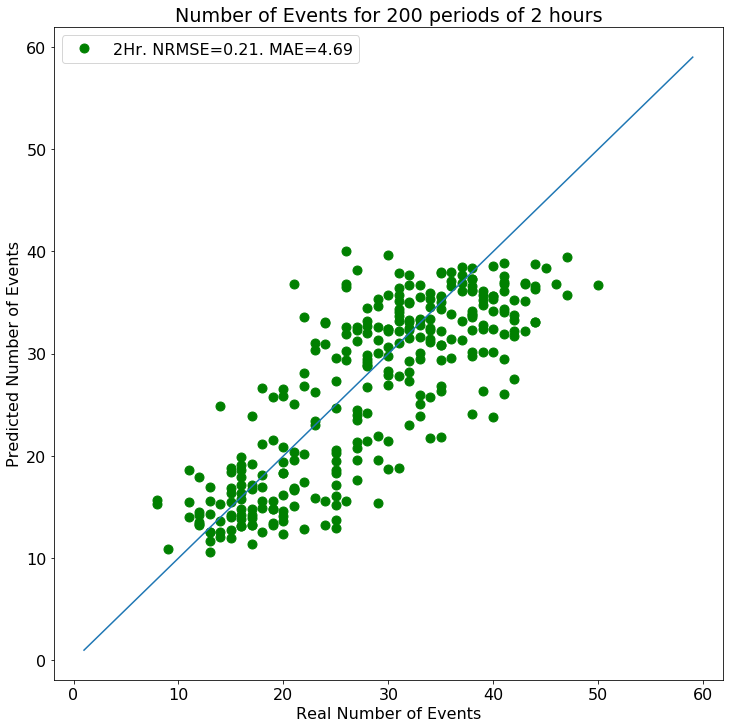

In [48]:
import sklearn.metrics
rmse2 = sqrt(sklearn.metrics.mean_squared_error(real_num_2h, pred_num_2h))/(np.mean(real_num_2h))

mae2 = sklearn.metrics.mean_absolute_error(real_num_2h, pred_num_2h)

plt.figure(figsize=(12,12))
plt.plot(real_num_2h, pred_num_2h, 'g.', label = "2Hr. NRMSE="+str(round(rmse2, 2))+". MAE="+str(round(mae2, 2)), markersize=18)
plt.xlabel('Real Number of Events')
plt.ylabel('Predicted Number of Events')
plt.legend()
plt.title('Number of Events for 200 periods of 2 hours')
x = np.arange(1, 60)
plt.plot(x, x)

In [86]:
st_indx = 100
pred = pred_num_2h[st_indx:] - percentile_2h[st_indx:]
neg_indx = pred < 0
pred[neg_indx] = 0
pos_indx = pred > 0
pred[pos_indx] = 1


real = real_num_2h[st_indx:] - np.percentile(real_num_2h, percentile)
neg_indx = real < 0
real[neg_indx] = 0
pos_indx = real > 0
real[pos_indx] = 1

In [87]:
import sklearn.metrics

sklearn.metrics.roc_auc_score(pred, real)

0.6765350877192983

In [53]:
num_events_in_top_percentile = 0
false_neg = 0
true_neg = 0
false_pos = 0
true_pos = 0

for i in range(0, len(real)):
    if real[i]:
        num_events_in_top_percentile += 1
    if real[i] and pred[i]:
        true_pos += 1
    elif real[i] and not pred[i]:
        false_neg += 1
    elif not real[i] and not pred[i]:
        true_neg +=1
    elif not real[i] and pred[i]:
        false_pos +=1
print("\nTot num top percentile events: ")
print(num_events_in_top_percentile)
print('\nTrue pos: ')
print(true_pos)
print("\nFalse neg: ")
print(false_neg)
print("\nFalse pos: ")
print(false_pos)
print("\nTrue neg: ")
print(true_neg)


Tot num top percentile events: 
38

True pos: 
7

False neg: 
31

False pos: 
8

True neg: 
154


### Checking Wasserstein

In [34]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
start_time = simulation._LastTime
num = 300
future_intensity, times, incr = simulation.get_future_events(start_time, num, 0)
future_intensity = sum(future_intensity)
wasserstein_locs = simulation.locs_for_wasserstein(start_time, num, top_percent=96)


In [35]:
wasserstein_locs

array([[ 3.98174959e+01, -8.63283000e+01,  3.28134056e+00],
       [ 3.98358633e+01, -8.63157174e+01,  1.51375308e+00],
       [ 3.98236184e+01, -8.62842609e+01,  1.18530988e+00],
       [ 3.98603531e+01, -8.62779696e+01,  4.36500372e+00],
       [ 3.98419857e+01, -8.62653870e+01,  5.78522942e-01],
       [ 3.97930061e+01, -8.62590957e+01,  3.17194883e-02],
       [ 3.98113735e+01, -8.62590957e+01,  7.56017032e-02],
       [ 3.98236184e+01, -8.62590957e+01,  1.05227077e+00],
       [ 3.98419857e+01, -8.62590957e+01,  3.45594068e+00],
       [ 3.96583122e+01, -8.62402217e+01,  2.38463576e+00],
       [ 3.97623939e+01, -8.62402217e+01,  4.14267463e+00],
       [ 3.97685163e+01, -8.62339304e+01,  6.20201343e-01],
       [ 3.97807612e+01, -8.62213478e+01,  3.00355549e-01],
       [ 3.97807612e+01, -8.62150565e+01,  2.41802005e-01],
       [ 3.97623939e+01, -8.62087652e+01,  7.88526260e-01],
       [ 3.97746388e+01, -8.62087652e+01,  1.15258776e+00],
       [ 3.97807612e+01, -8.62087652e+01

In [36]:
cluster = Cluster(wasserstein_locs, n = 6)
cluster.randomize_centers()
lam = cluster.learn_lam(n_iter=8, rand_centers=False)
centers= cluster.get_centers()
centers_grid_x = np.zeros(len(centers))
centers_grid_y = np.zeros(len(centers))

for i in range(0, len(centers)):
    x, y = simulation.coord_to_grid(centers[i][1], centers[i][0])
    centers_grid_x[i] = x
    centers_grid_y[i] = y
centers_grid_x, centers_grid_y

[3.243472627563439, 35.0]
[3.008569352812076, 55.0]
[2.8209847014342104, 74.0]
[2.808558841574331, 92.0]
[2.4622758984626407, 109.0]
[2.889817586633293, 125.0]
[2.021541543095909, 124.0]
[2.1416292214822055, 120.25]
Iteration:  7


(array([32., 26., 27., 15., 44., 27.]), array([24., 23., 20., 25., 25., 28.]))

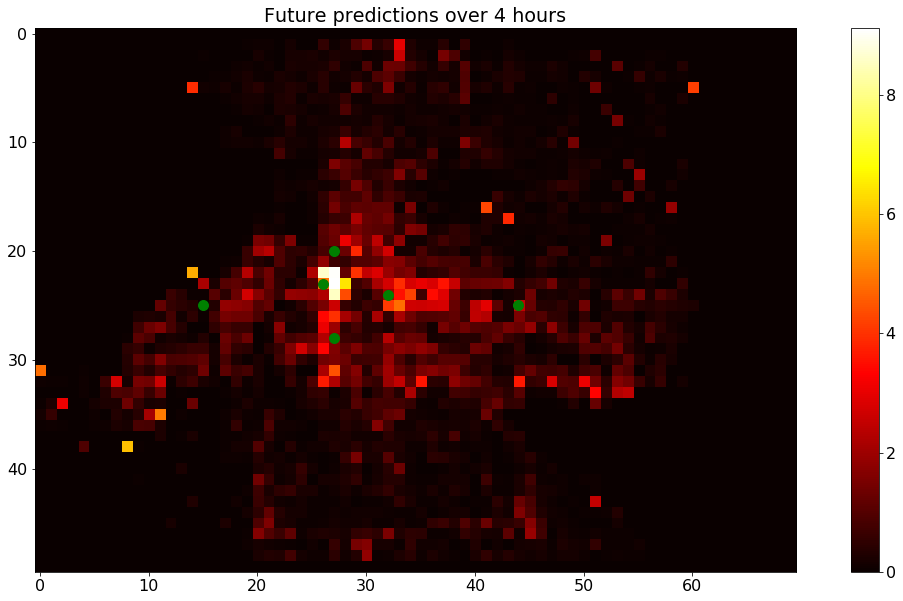

In [37]:
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(future_intensity),cmap='hot', interpolation = 'nearest')
plt.title('Future predictions over 4 hours')
plt.plot(centers_grid_x, centers_grid_y, 'g.', markersize = 20)
plt.colorbar()
plt.show()